Description:  This script produces Figures 4,5, and 6 (plan view plots for lma gridded products like flash source density, flash footrpint, and flash initiation density overlaid with the identified ZDR column objects.)

In [6]:
from skimage import io
import os,glob
import xarray as xr
from matplotlib import colors
from matplotlib import patches
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import pandas as pd
from skimage.morphology import remove_small_objects, watershed, dilation, erosion, ball     # function for post-processing (size filter)
from skimage.feature import peak_local_max
from skimage.measure import label,regionprops,regionprops_table
from skimage import io

# load custom colormaps
import cmap_footprint_b13
import cmap_extent_density_b13

plt.rcParams['figure.figsize'] = [12,8]
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20
plt.rcParams['legend.fontsize'] = 20
plt.rcParams['legend.markerscale'] = 2

#### STEP 1: Object IDs of identified ZDR columns in our segmentation process

In [2]:
# after manual verification of all the ZDR column objects at the 4km level, we list out the ones that are embedded within Edmond-Carney storm
# This should filter out artifacts (due to gridding or contamination from nearby storms)
# each list within the obj_interest list specifies the object labels that are of our interest. 
# There are 42 such lists in obj_interest corresponding to all the times for which we have gridded radar data

# DO NOT change this!

obj_interest = [[3],[2],[2],[1,2],[3],[1],[2,3],[2,3,4,5],[5,6],[2],[4,5],[3,4],[2,3],[2,3],[5,6],[3],[4,5],[3,4],[3,4],[1,2],[3,4],[6,7,9],
                [1,2,3],[3,4,5],[2,3],[2,3,4,5],[1,2,3],[1,2],[2,3],[2,3],[1,4],[1,2],[1,2],[2,3],[1,2],[3,4,5],[1],[np.nan],[np.nan],[np.nan],[np.nan],[np.nan]]

#### STEP 2: Next, we capture the coordinates and label of bounding boxes around zdr column objects

#### This way we can calculate the flash initiation density specifically within the region of zdr column objects

In [3]:
# Here we load the segmentation output files and get datetime objects for each time step from radar files 

segmented_files = sorted(glob.glob('./data_files/segmented_stacks/zdr/direct_array/*tiff'))

rad_files = sorted(glob.glob('path/to/KTLX_data/*V06'))
tmpstmps = [x.split('/')[-1][4:19] for x in rad_files]     #access the time stamps from each radar file and convert those into datetime objects
dt_tmpstmps = [datetime.strptime(x,"%Y%m%d_%H%M%S") for x in tmpstmps]

In [4]:
# Here, we create a dataframe which stores the bbox region coordinates and label values for zdr column objects
# NOTE: These zdr column objects were identified from the segmentation result using direct array
# and not by reding files using the AICSImage reader. 

segmented_files = sorted(glob.glob('/Users/ms/Desktop/mount/May_19_2013_all_stuff/segmentation_direct_array_zdr/*.tiff'))

final_zdr_df = pd.DataFrame()
for i in range(len(segmented_files)):

    cell_seg_reader = io.imread(segmented_files[i])
    cell_seg = cell_seg_reader
    seg = label(cell_seg)
    seg = np.fliplr(seg)

    # cell_seg = label(cell_seg[:,::-1,:])
    props = regionprops_table(seg,properties=['bbox','bbox_area','label'])
    
    df = pd.DataFrame(props)
    #     df.drop(labels=['time'],axis=1,inplace=True)

    df['time'] = dt_tmpstmps[i]
    df.index = df['time']
    df.drop(labels=['time'],axis=1,inplace=True)

    df_sel = df[df["label"].isin(obj_interest[i])]
    # append zdr_col info df for current time step to the final_df
    final_zdr_df = final_zdr_df.append(df_sel,)

#### STEP 3: Finally, we plot all our analysis in a nice looking figure with subplots

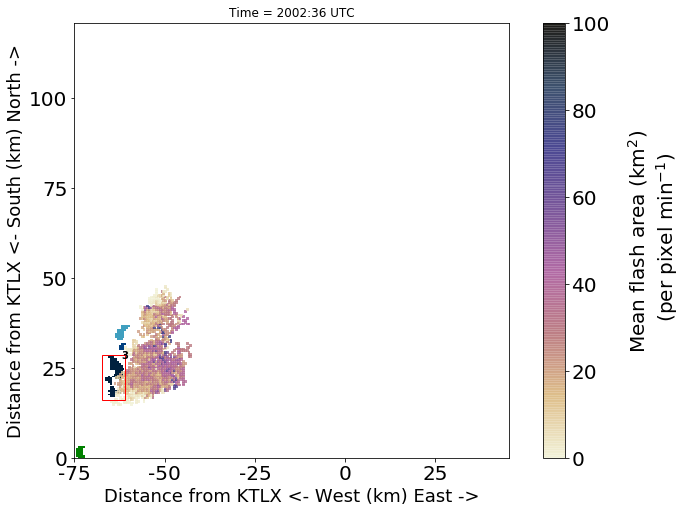

Frame 0 done


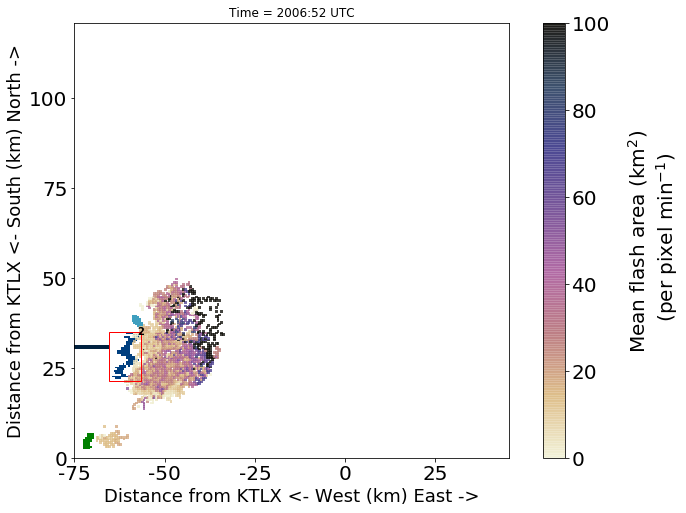

Frame 1 done


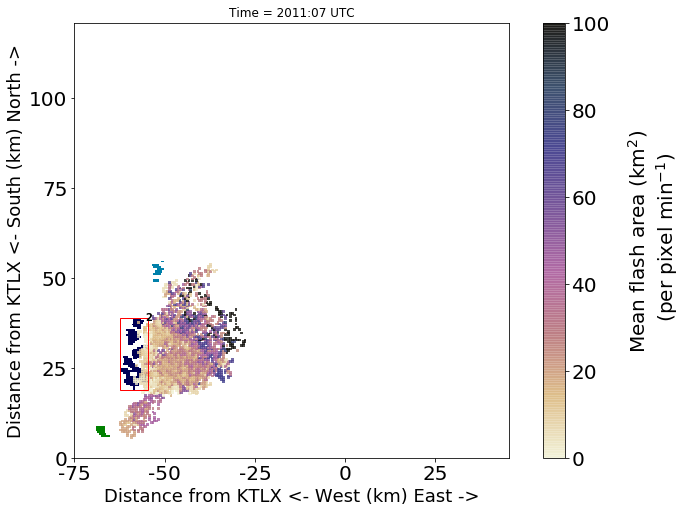

Frame 2 done


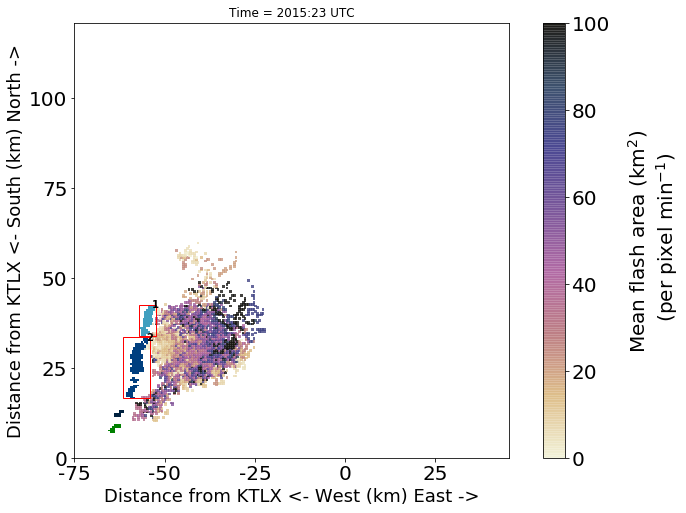

Frame 3 done


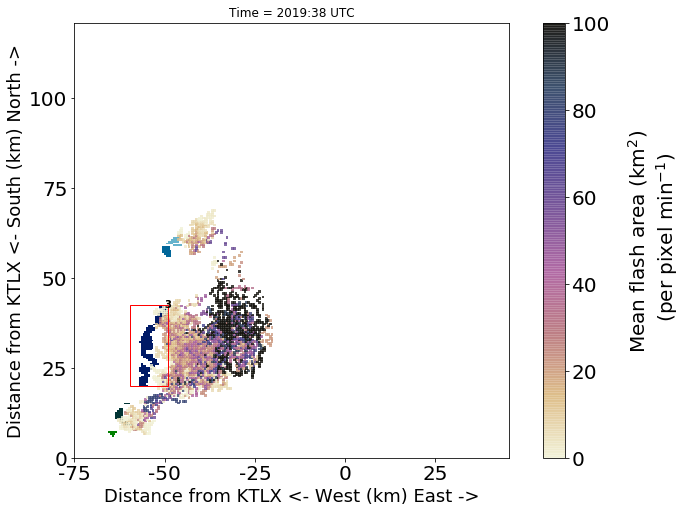

Frame 4 done


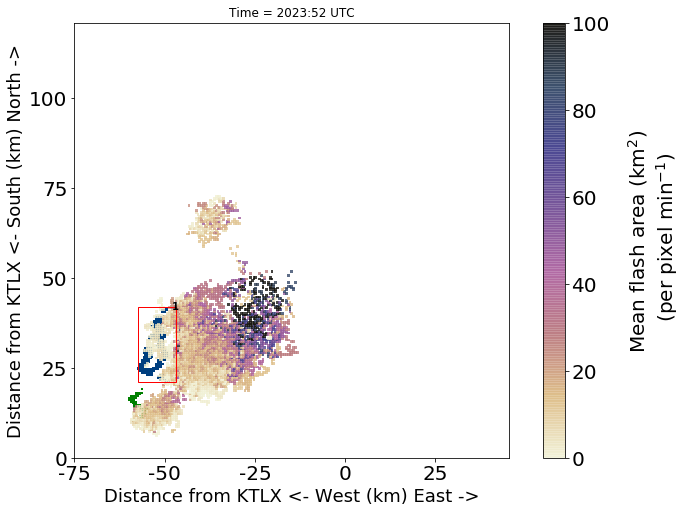

Frame 5 done


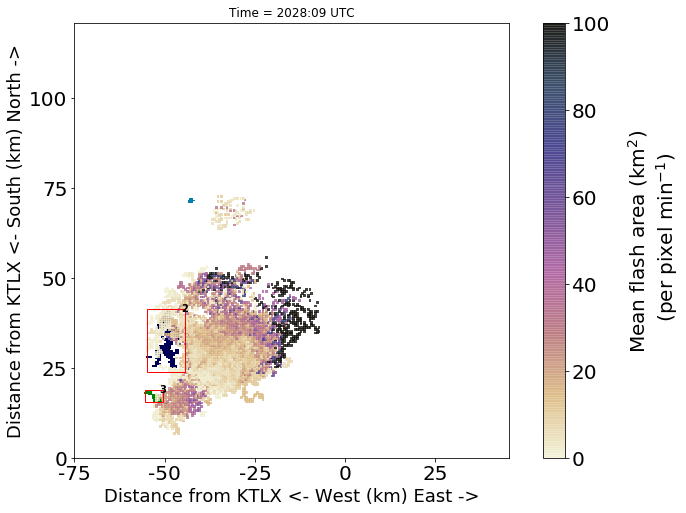

Frame 6 done


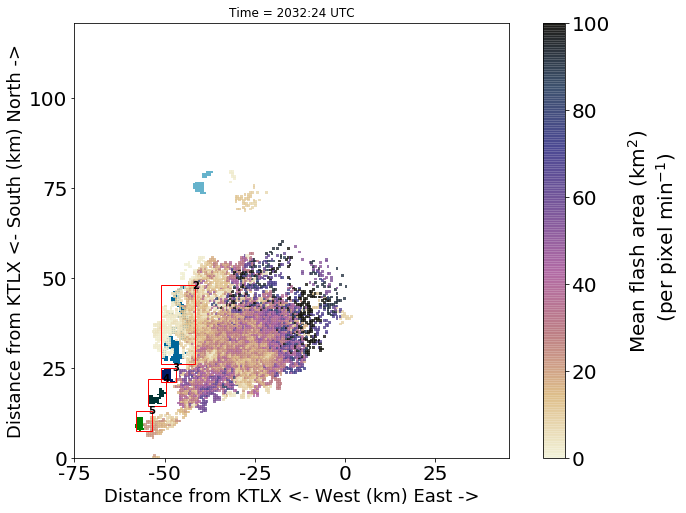

Frame 7 done


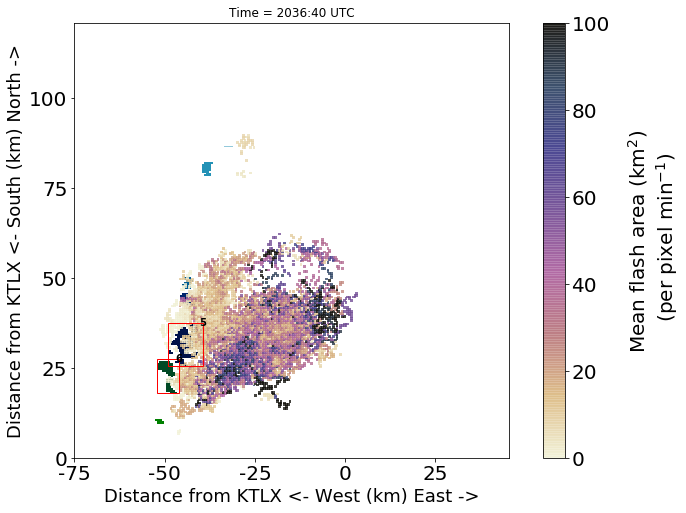

Frame 8 done


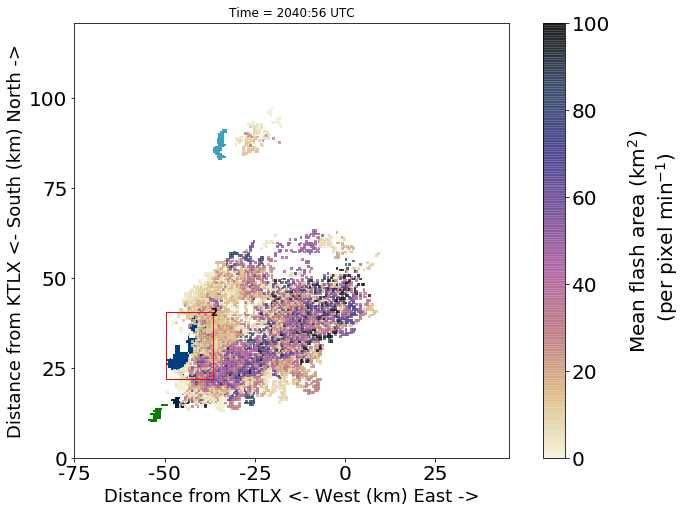

Frame 9 done


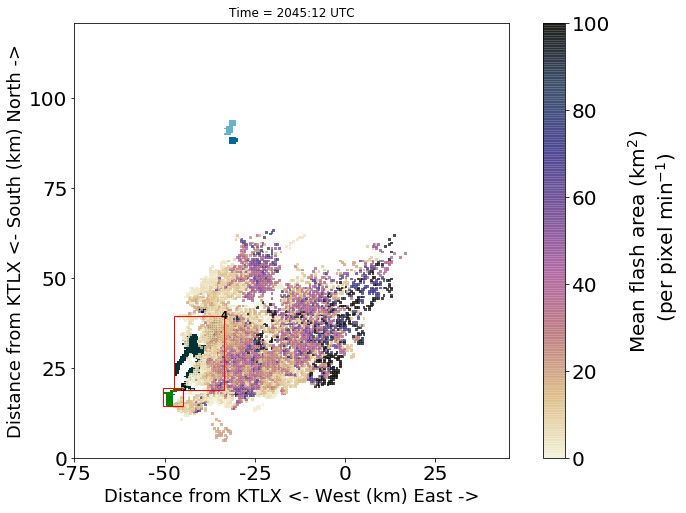

Frame 10 done


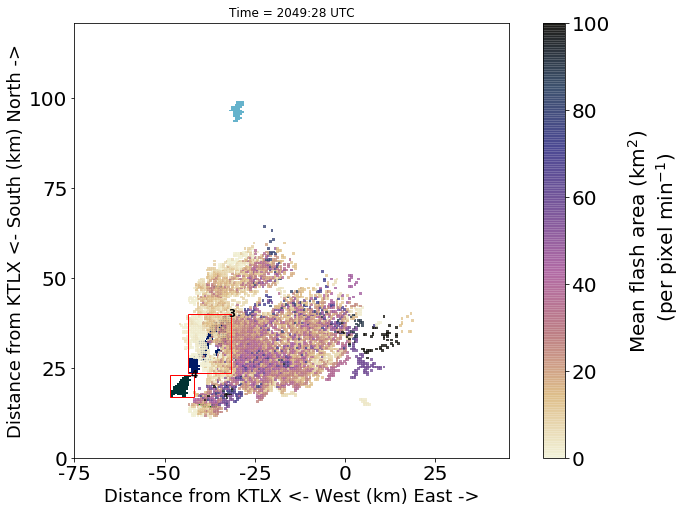

Frame 11 done


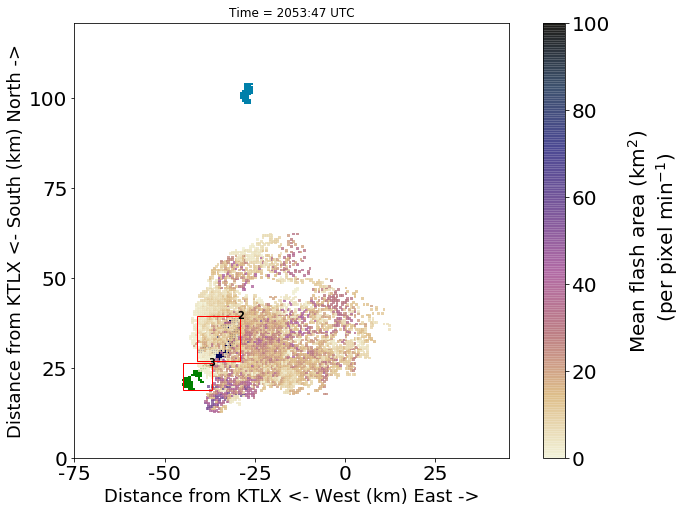

Frame 12 done


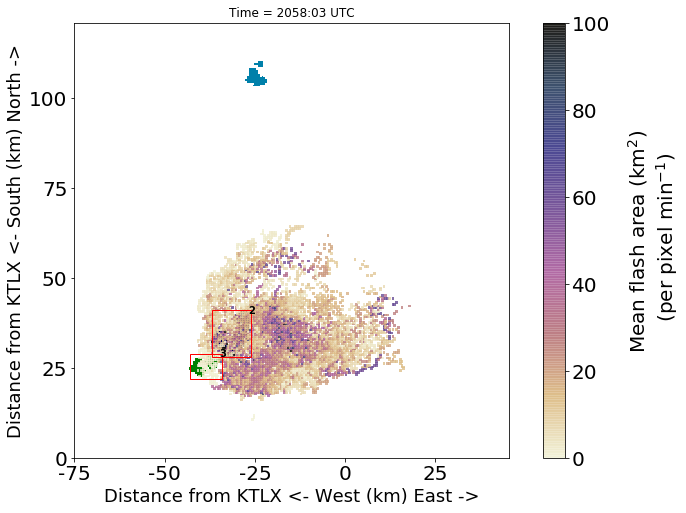

Frame 13 done


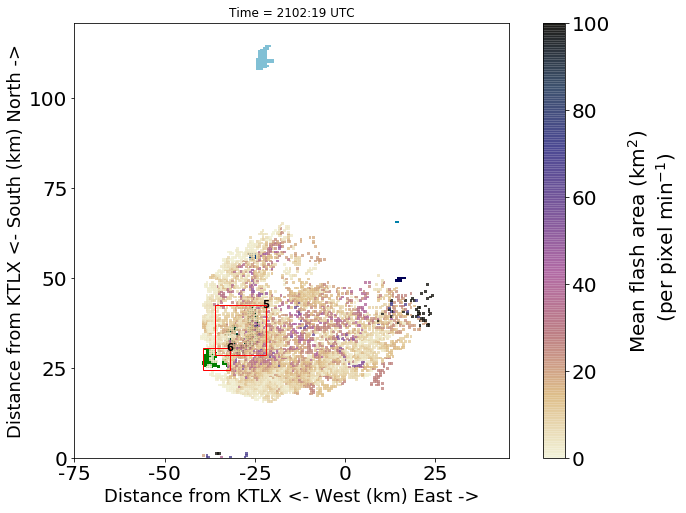

Frame 14 done


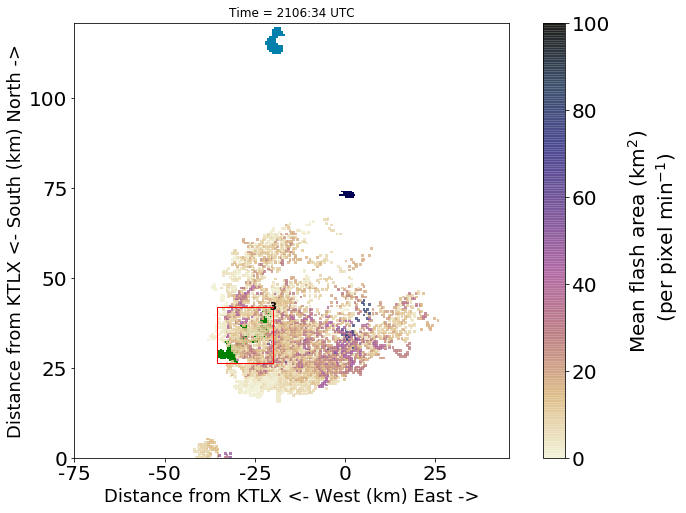

Frame 15 done


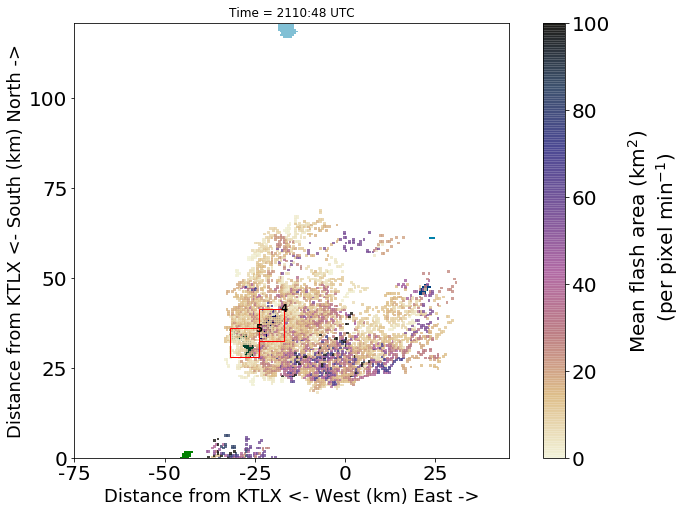

Frame 16 done


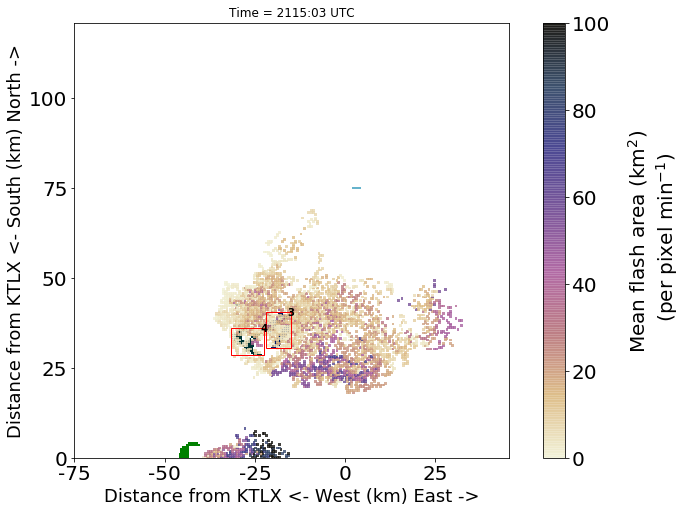

Frame 17 done


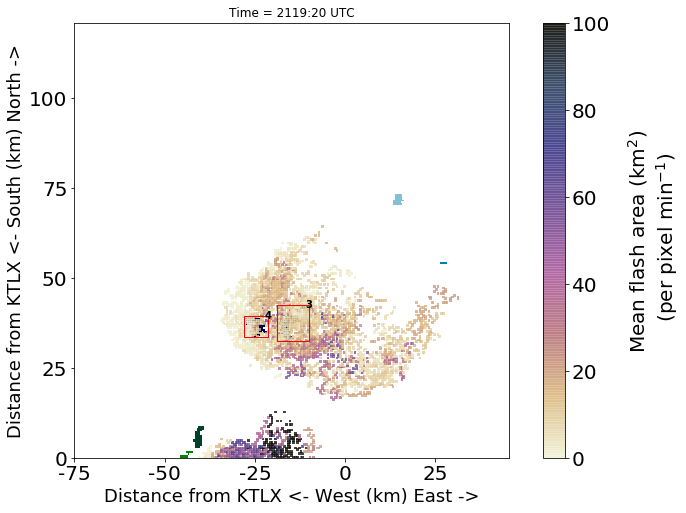

Frame 18 done


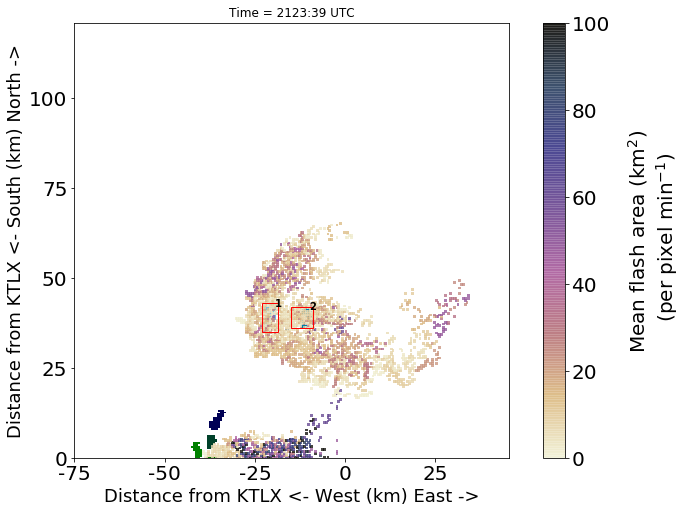

Frame 19 done


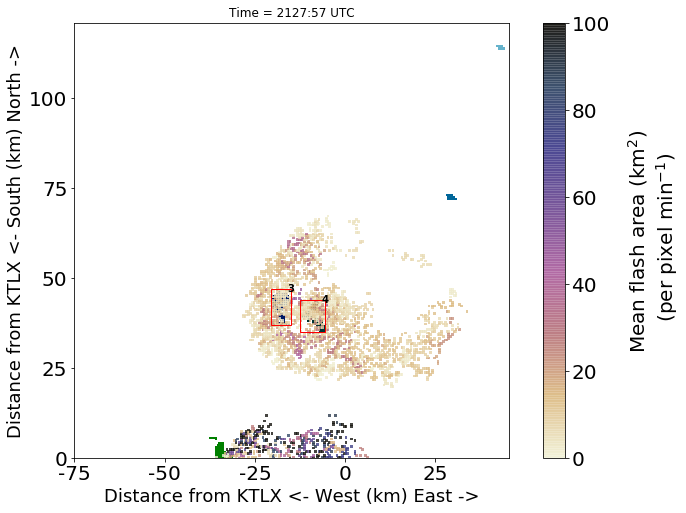

Frame 20 done


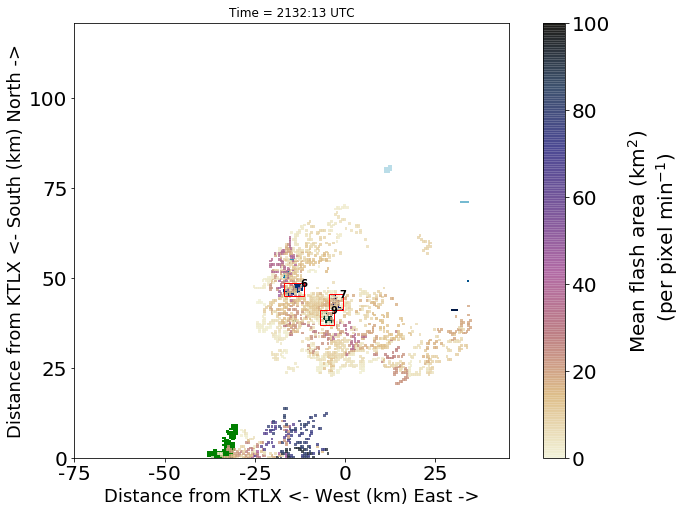

Frame 21 done


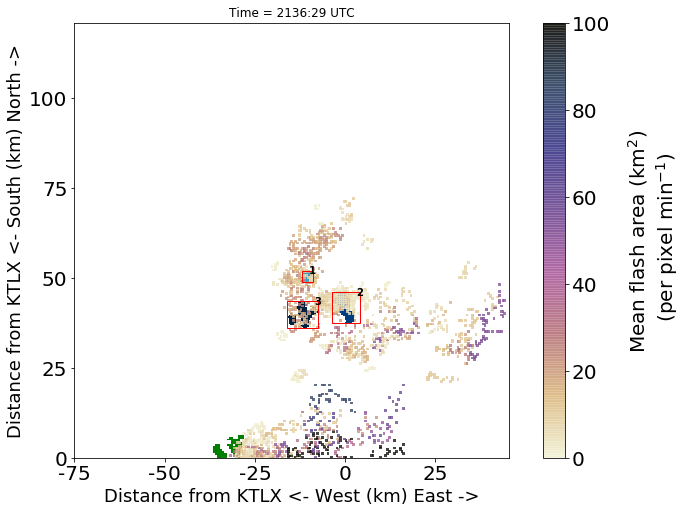

Frame 22 done


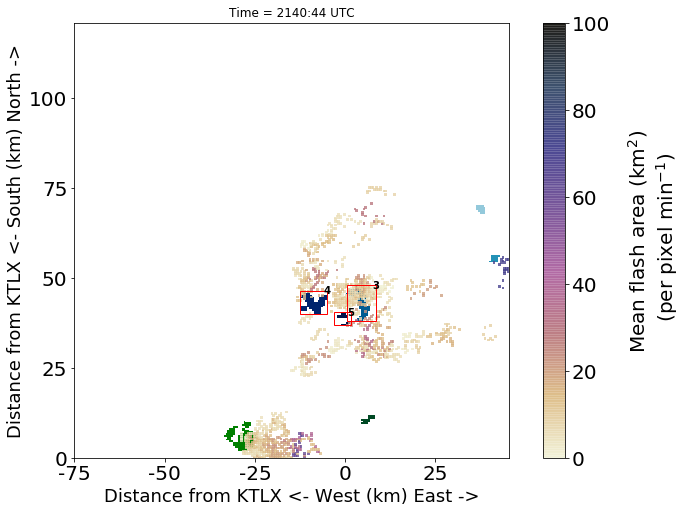

Frame 23 done


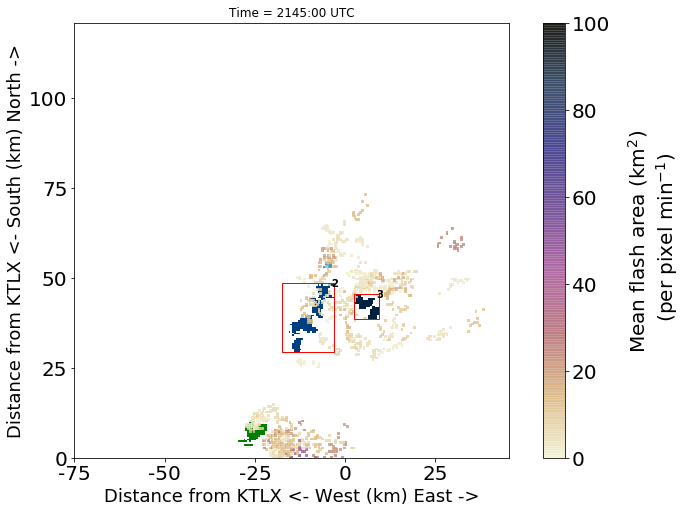

Frame 24 done


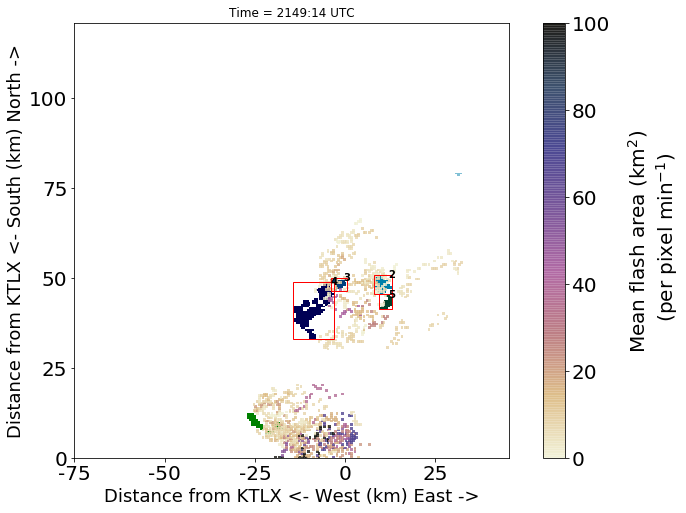

Frame 25 done


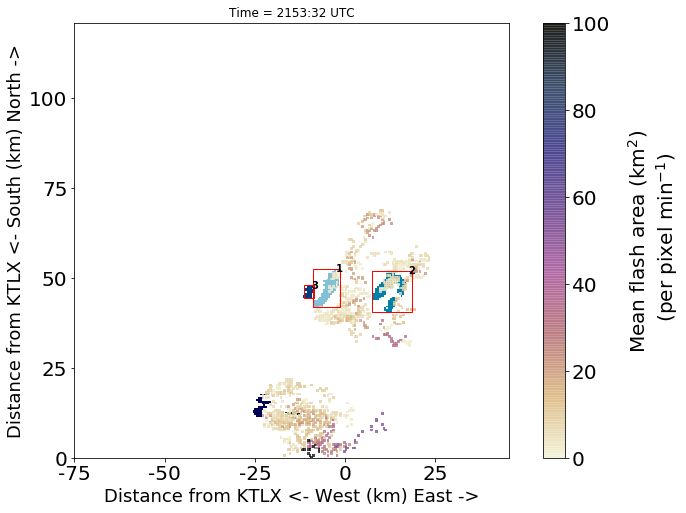

Frame 26 done


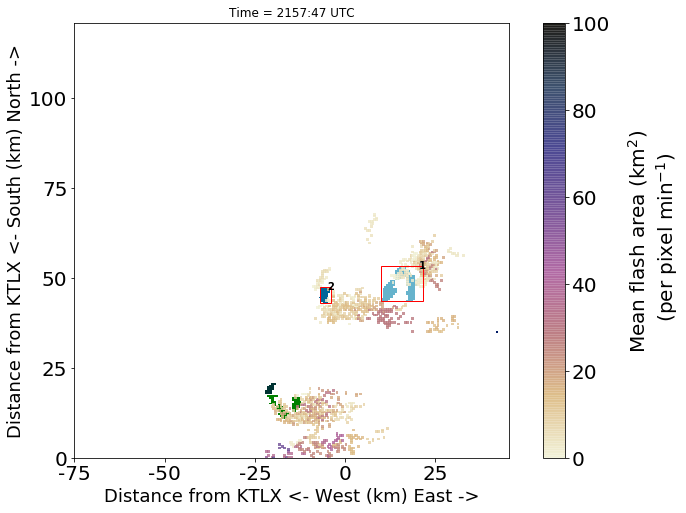

Frame 27 done


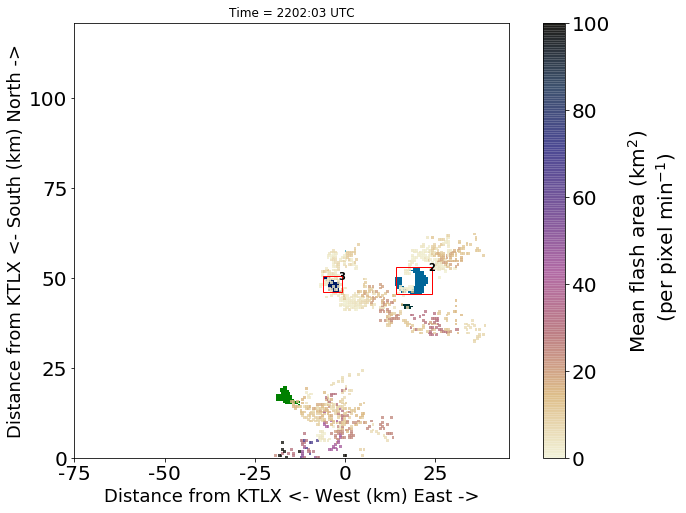

Frame 28 done


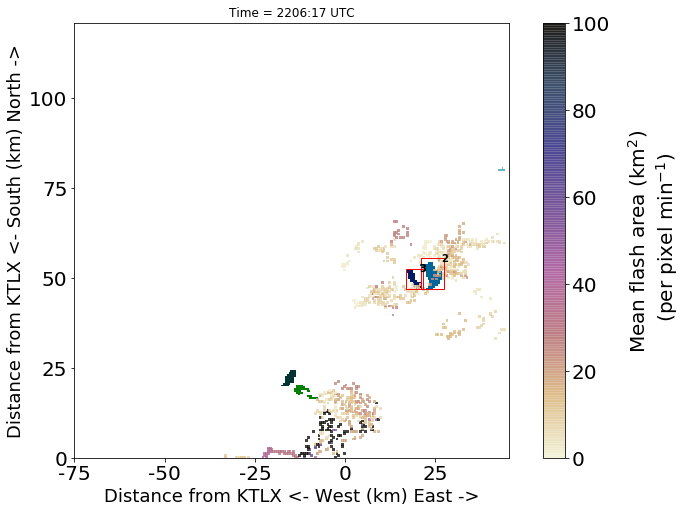

Frame 29 done


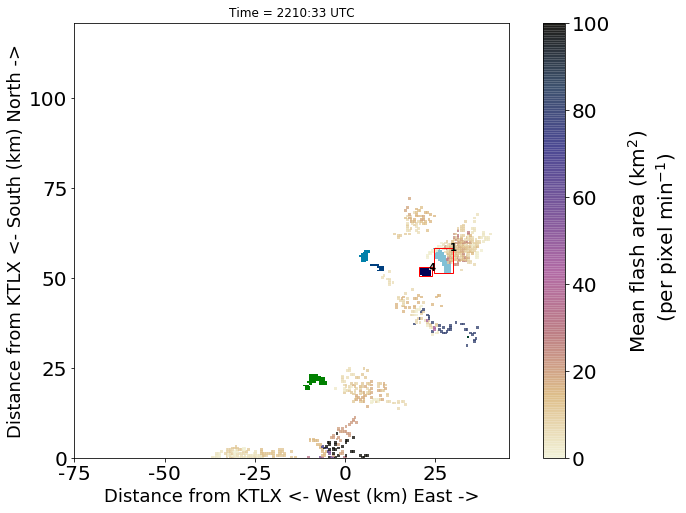

Frame 30 done


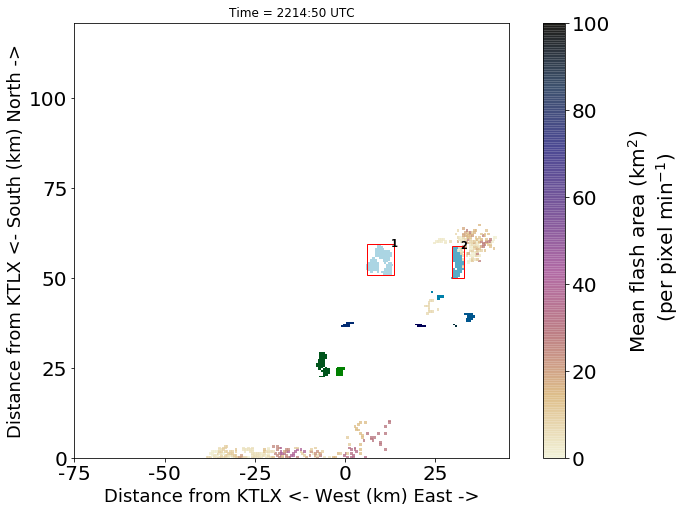

Frame 31 done


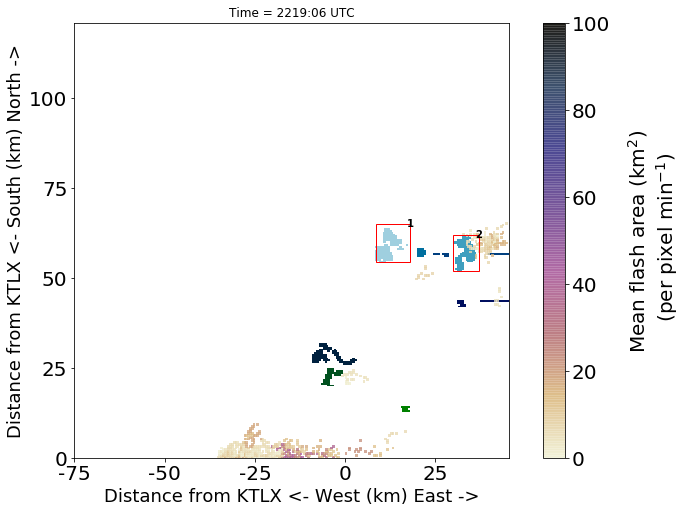

Frame 32 done


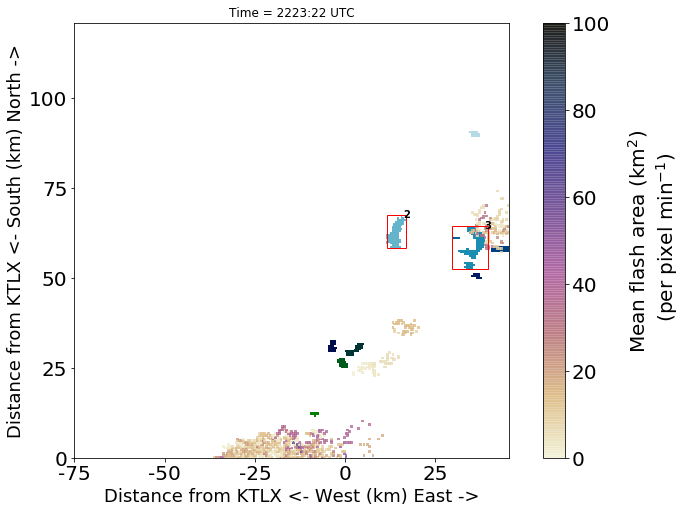

Frame 33 done


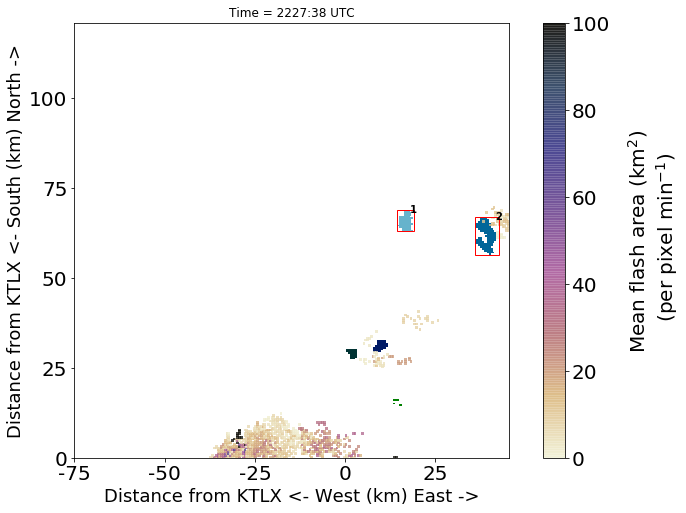

Frame 34 done


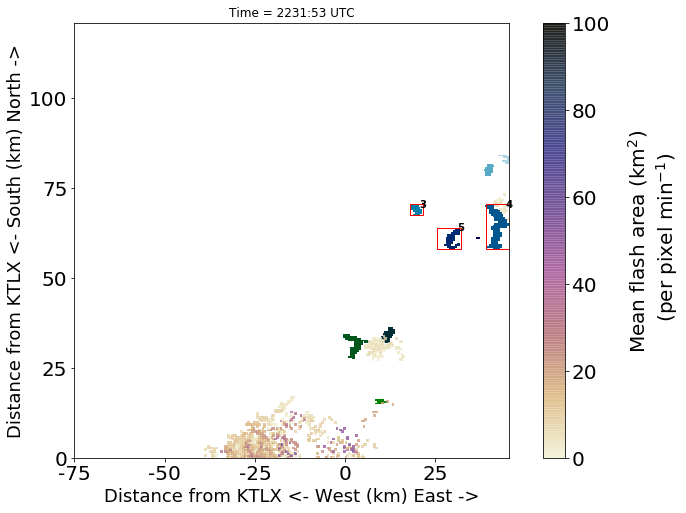

Frame 35 done


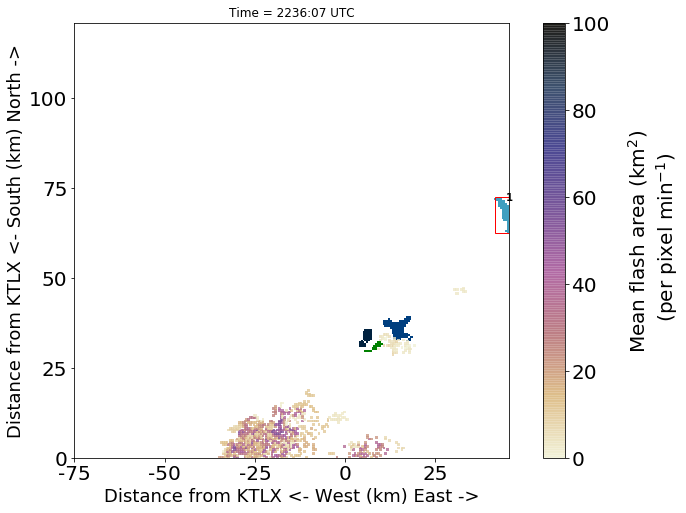

Frame 36 done


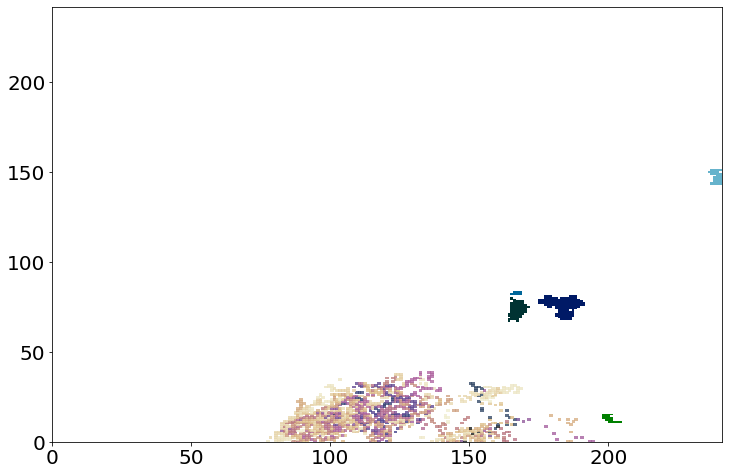

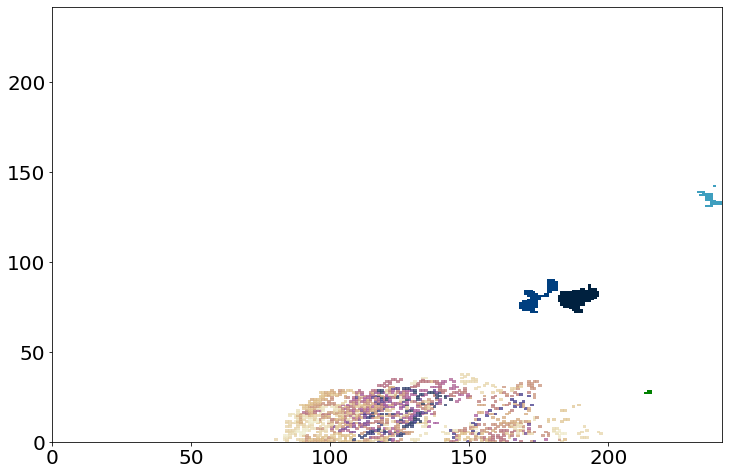

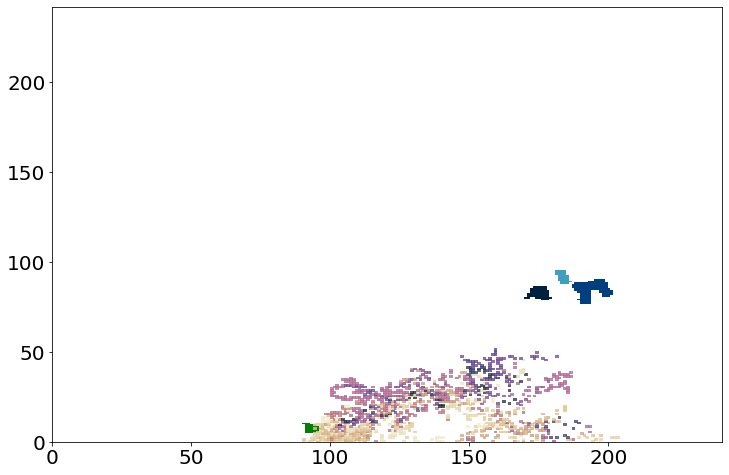

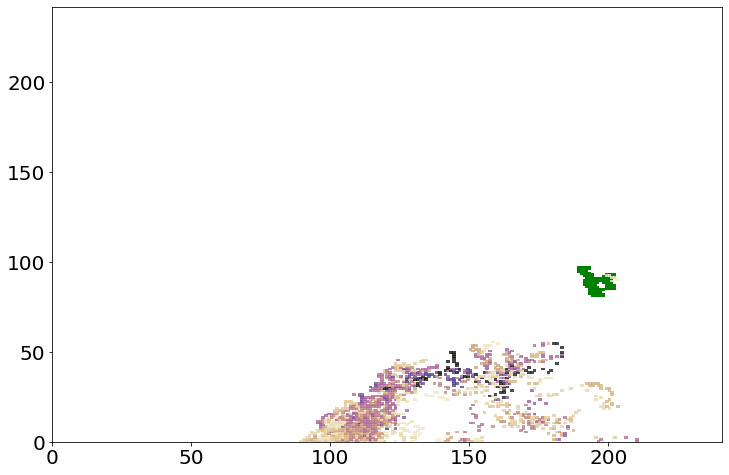

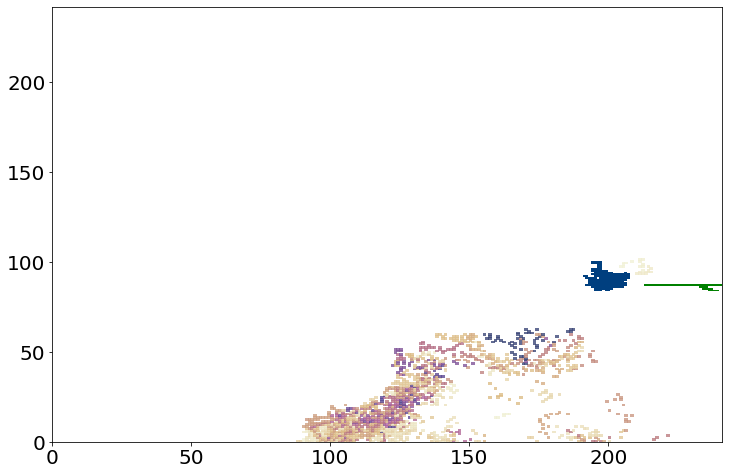

In [7]:
# This piece of code plots and overlays identified zdr column objects on top of flash footprint density
# We save these individual overlay plots to be able to create a gif stack later

ds = xr.open_mfdataset('/Users/ms/Desktop/mount/May_19_2013_all_stuff/May19_LMA_sorted/flashsort/grid_files20002300_per_radar_grid_500x500x500m_KTLX/2013/May/19/*_footprint.nc',combine='nested',concat_dim='ntimes')
rot_corrected_flash_foot = np.swapaxes(ds.flash_footprint,1,2)
rot_corrected_flash_foot = rot_corrected_flash_foot.where(rot_corrected_flash_foot > 0 )

for i in range(ds.dims['ntimes']):
    fig,ax = plt.subplots(1)
    tidx = dt_tmpstmps[i]
    obj_bounds = pd.DataFrame()

    cell_seg_reader = io.imread(segmented_files[i])
    cell_seg = cell_seg_reader
    seg = label(cell_seg)
    seg = np.fliplr(seg)

    ax.pcolormesh(seg[0,:,:],cmap='ocean_r',alpha=1)
    fig = ax.pcolormesh(rot_corrected_flash_foot[i,:,:],cmap='footprint_b13',alpha=0.8,vmin=0,vmax=100)

    
    try:
        obj_bounds = pd.DataFrame(final_zdr_df.loc[tidx])
        
        if len(obj_bounds.columns) ==1:
            obj = obj_bounds.transpose()
            rect = patches.Rectangle((obj['bbox-2'][0],obj['bbox-1'][0]),obj['bbox-5'][0]-obj['bbox-2'][0],obj['bbox-4'][0]-obj['bbox-1'][0],linewidth=1,edgecolor='r',facecolor='none')
            ax.annotate(obj['label'][0], (obj['bbox-5'][0],obj['bbox-4'][0]), color='k', weight='bold',fontsize=10, ha='center', va='center')
            # Add the patch to the Axes
            ax.add_patch(rect)
            cbar = plt.colorbar(mappable=fig)
            cbar.set_label('Mean flash area (km$^{2}$) \n (per pixel min$^{-1}$)', fontsize = 20, labelpad=16)
            ratio = 1
            xleft, xright = ax.get_xlim()
            ybottom, ytop = ax.get_ylim()
            # the abs method is used to make sure that all numbers are positive
            # because x and y axis of an axes maybe inversed.
            ax.set_aspect(abs((xright-xleft)/(ybottom-ytop))*ratio)
            ax.set_xticklabels(['-75','-50','-25','0','25'])     # since #grid cells = 241 correspond to half the distance dx=dy=500m
            ax.set_yticklabels(['0','25','50','75','100'])
            ax.set_xlabel('Distance from KTLX <- West (km) East ->')
            ax.set_ylabel('Distance from KTLX <- South (km) North ->')
            fsavename = segmented_files[i].split('/')[-1].split('.')[0]
            raw_title  = datetime.strptime(segmented_files[i].split('/')[-1].split('.')[0],'%H%M%S')
            final_title = datetime.strftime(raw_title,'%H%M:%S') + ' UTC'
            
            plt.title(f'Time = {final_title}')
            plt.show()
            
        if len(obj_bounds.columns) >1:
            for j in range(len(obj_bounds)):
                obj = pd.DataFrame(obj_bounds.iloc[j]).transpose()
                rect = patches.Rectangle((obj['bbox-2'][0],obj['bbox-1'][0]),obj['bbox-5'][0]-obj['bbox-2'][0],obj['bbox-4'][0]-obj['bbox-1'][0],linewidth=1,edgecolor='r',facecolor='none')
                ax.annotate(obj['label'][0], (obj['bbox-5'][0],obj['bbox-4'][0]), color='k', weight='bold',fontsize=10, ha='center', va='center')
                # Add the patch to the Axes
                ax.add_patch(rect)
#                 ax.colorbar()
            cbar = plt.colorbar(mappable=fig)
            cbar.set_label('Mean flash area (km$^{2}$) \n (per pixel min$^{-1}$)', fontsize = 20, labelpad=16)
            ratio = 1
            xleft, xright = ax.get_xlim()
            ybottom, ytop = ax.get_ylim()
            # the abs method is used to make sure that all numbers are positive
            # because x and y axis of an axes maybe inversed.
            ax.set_aspect(abs((xright-xleft)/(ybottom-ytop))*ratio)
            ax.set_xticklabels(['-75','-50','-25','0','25'])     # since #grid cells = 241 correspond to half the distance dx=dy=500m
            ax.set_yticklabels(['0','25','50','75','100'])
            ax.set_xlabel('Distance from KTLX <- West (km) East ->')
            ax.set_ylabel('Distance from KTLX <- South (km) North ->')
            fsavename = segmented_files[i].split('/')[-1].split('.')[0]
            raw_title  = datetime.strptime(segmented_files[i].split('/')[-1].split('.')[0],'%H%M%S')
            final_title = datetime.strftime(raw_title,'%H%M:%S') + ' UTC'
            
            plt.title(f'Time = {final_title}')
            plt.show()
    
    except KeyError as error:    # happens when  obj_pounds is empty (zero entries) i.e. no ZDR objects to identify in our data
        continue        

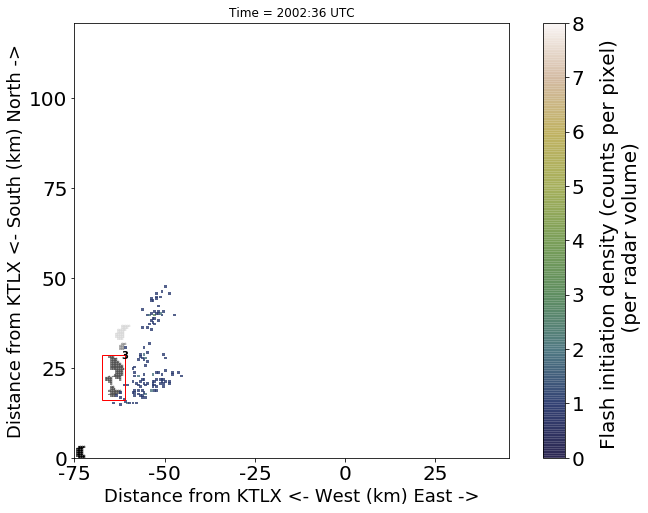

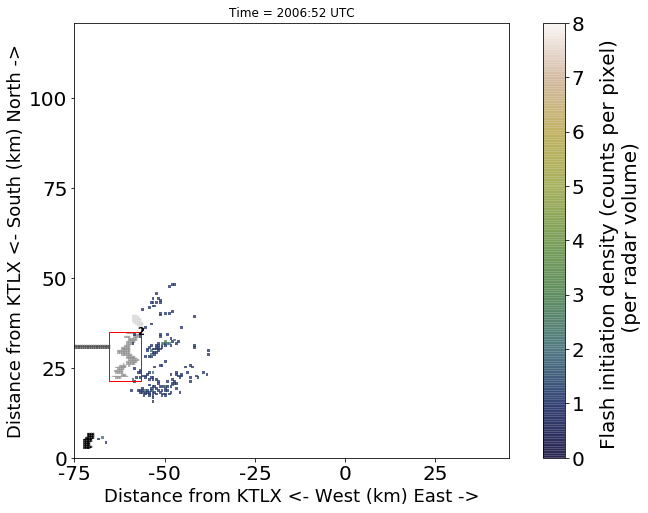

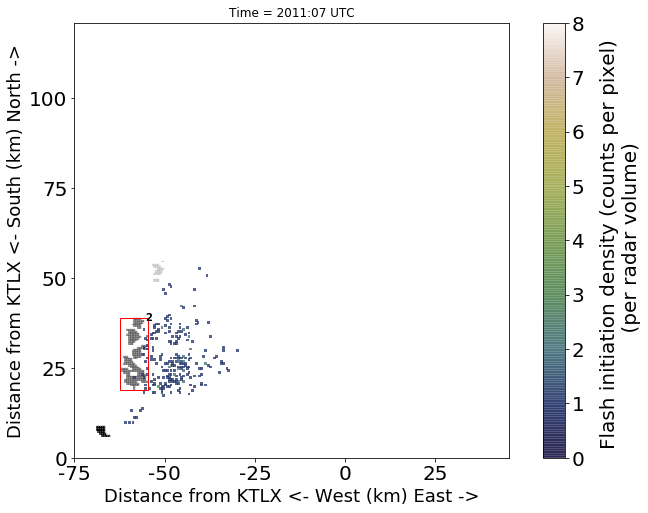

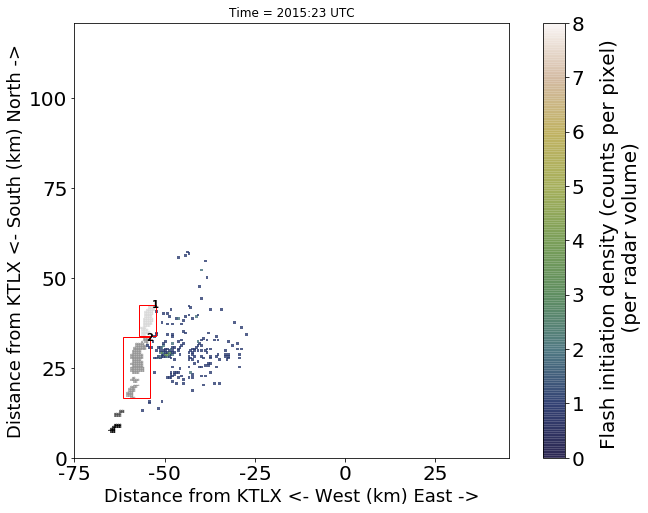

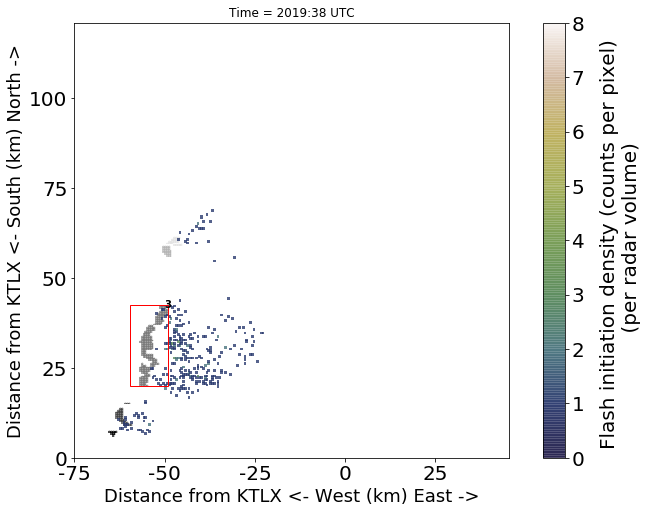

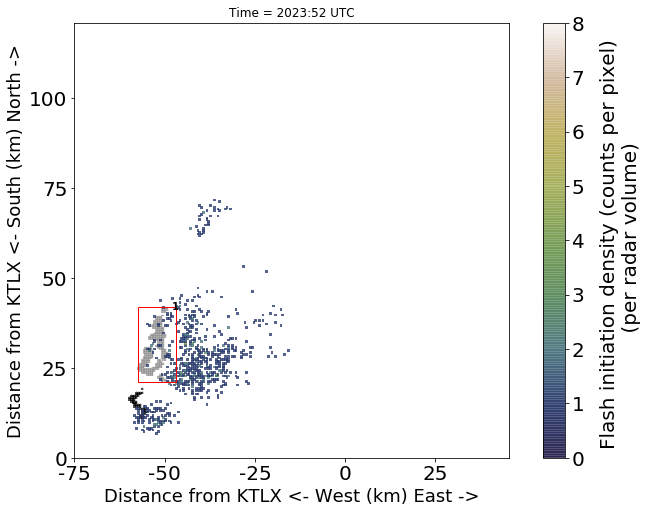

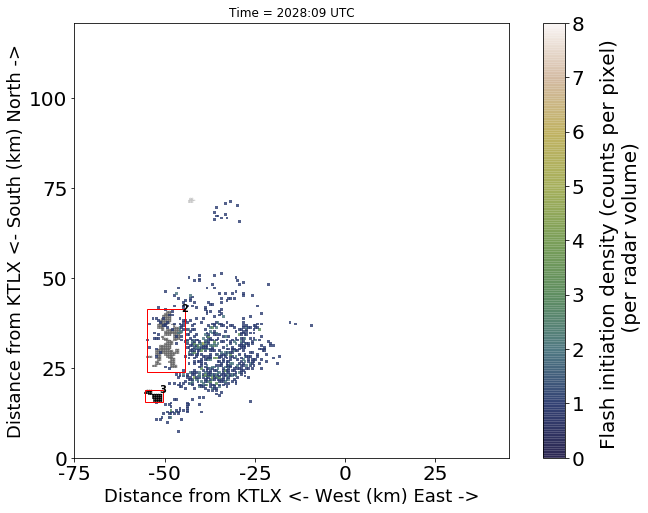

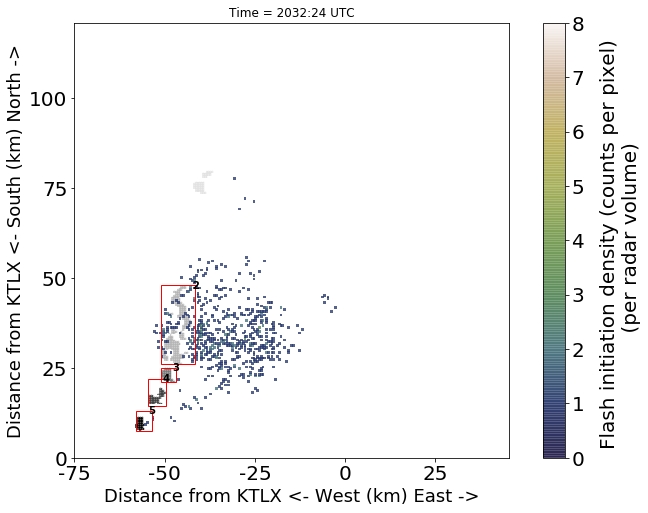

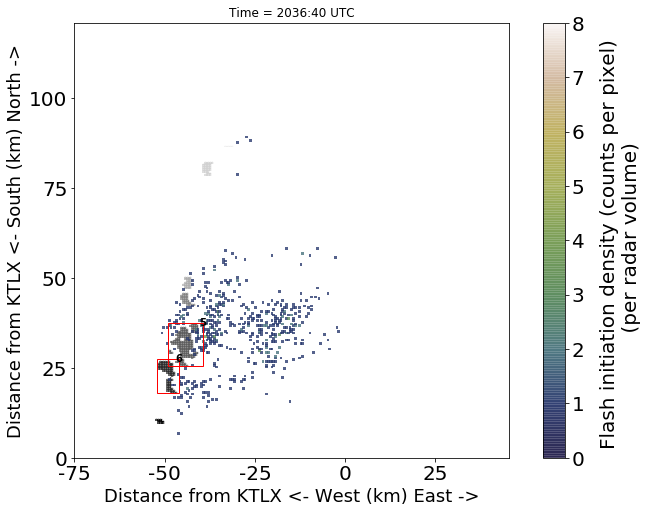

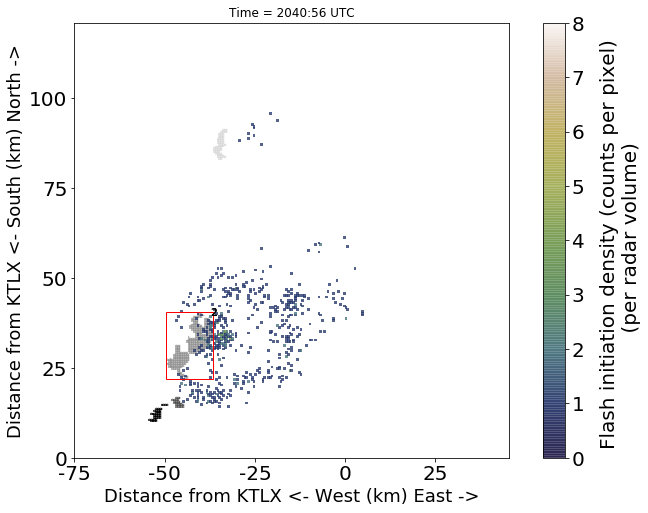

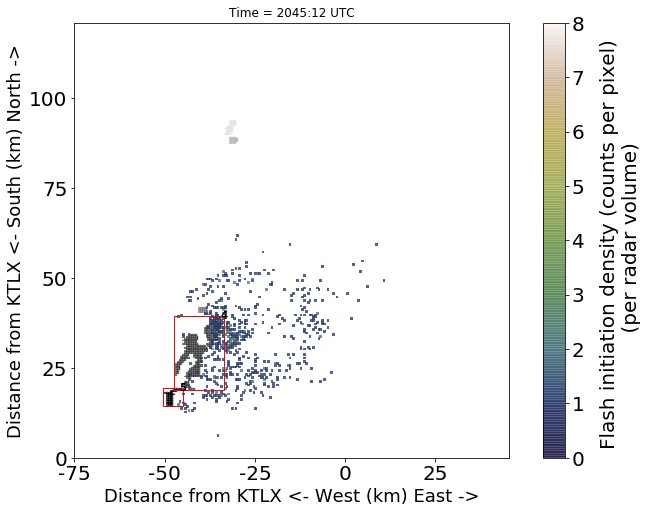

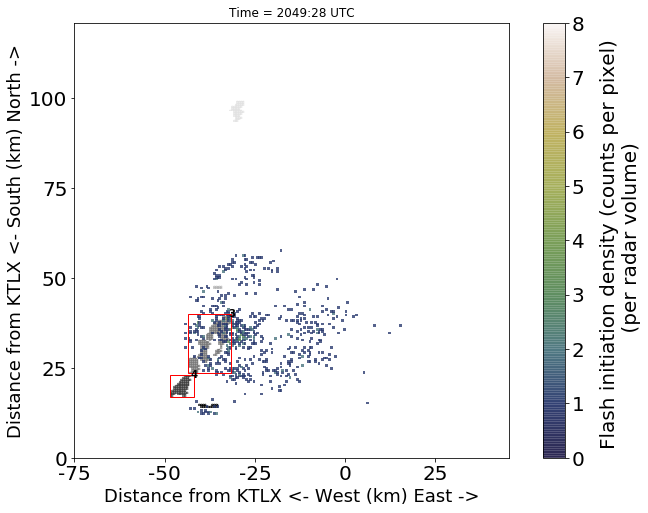

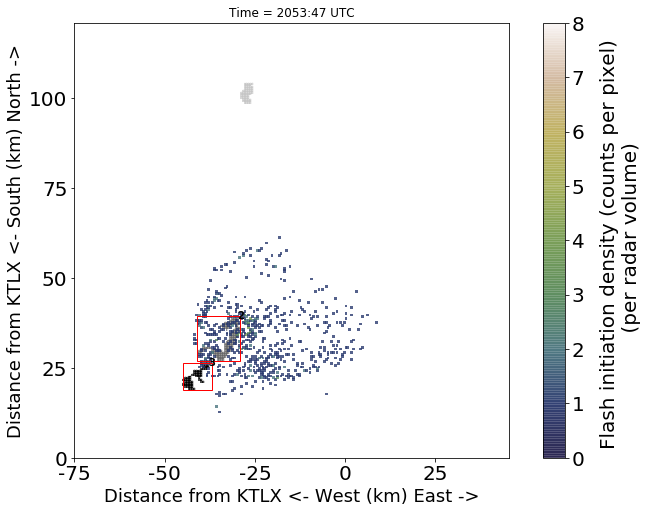

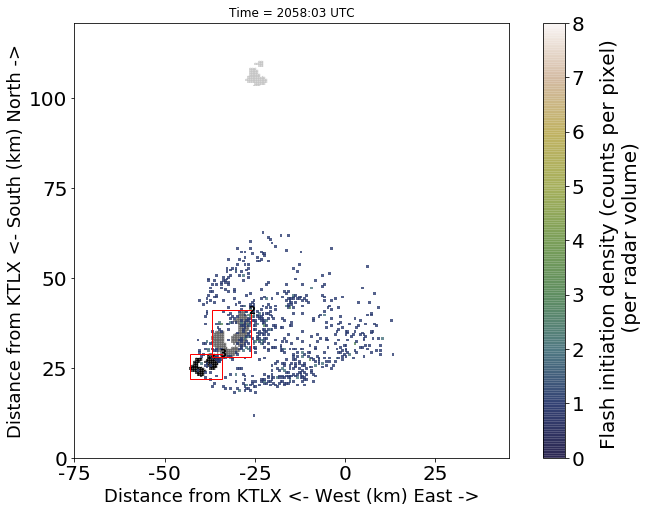

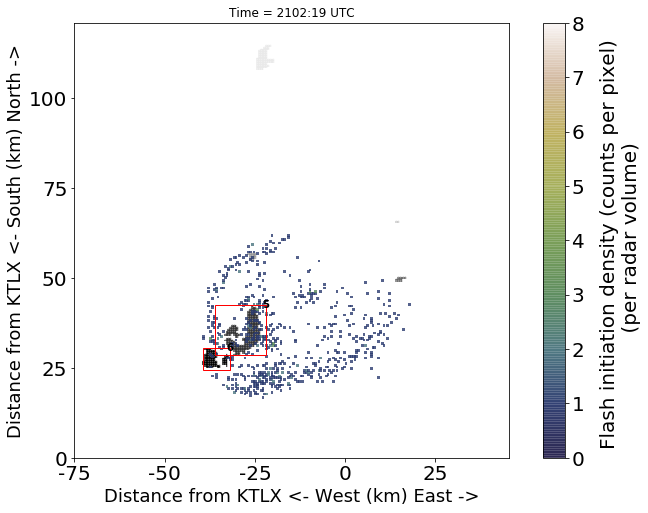

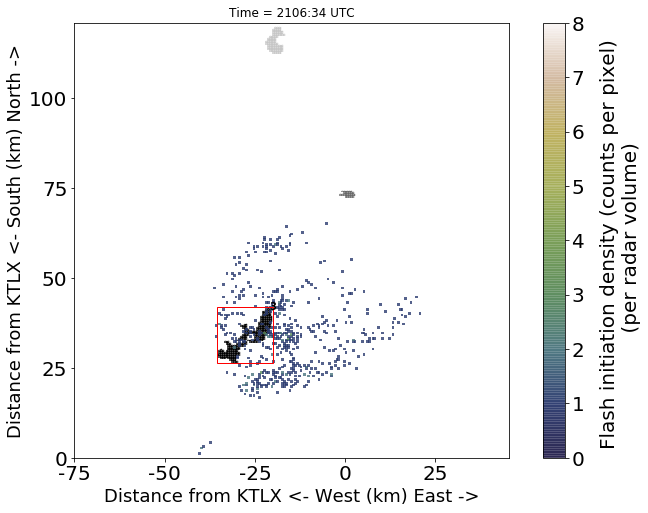

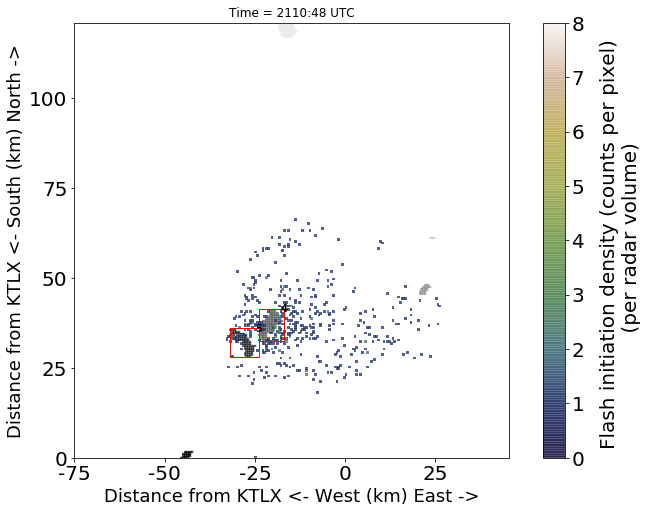

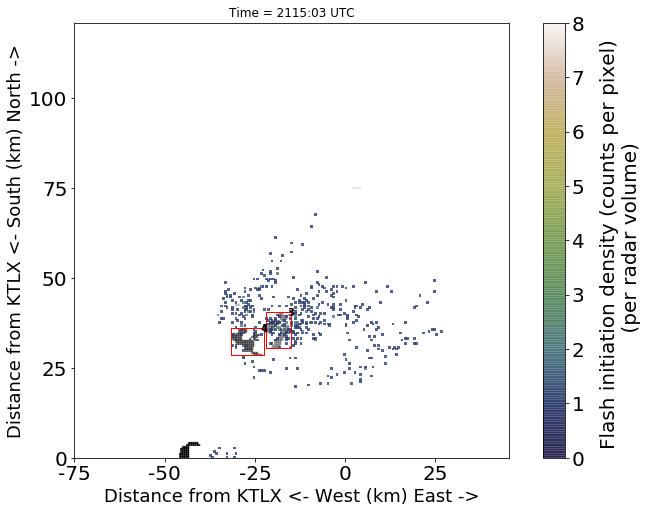

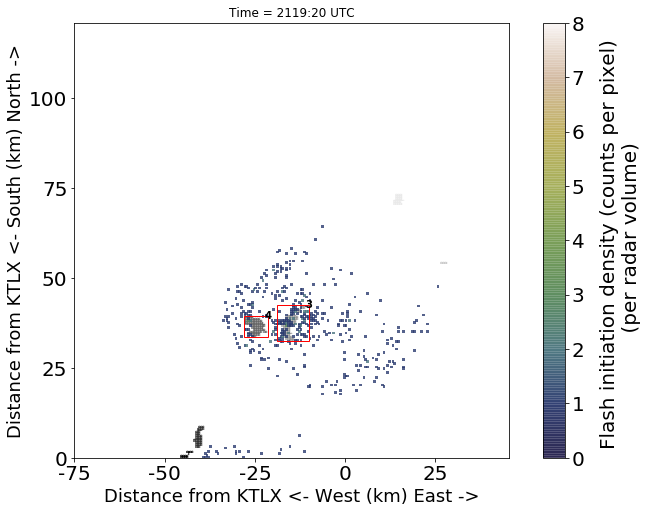

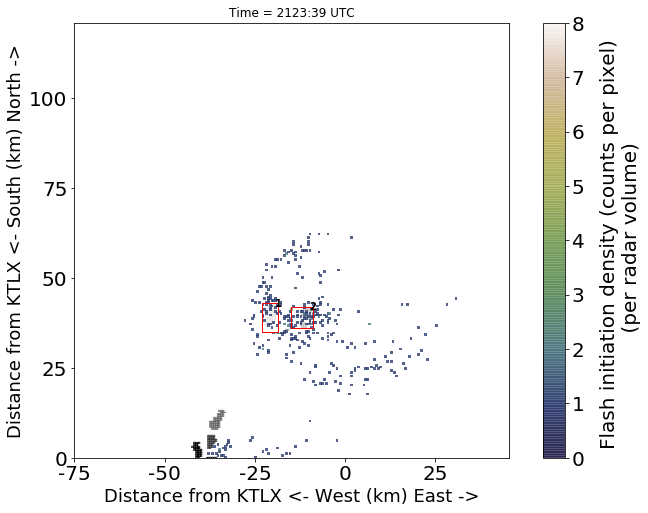

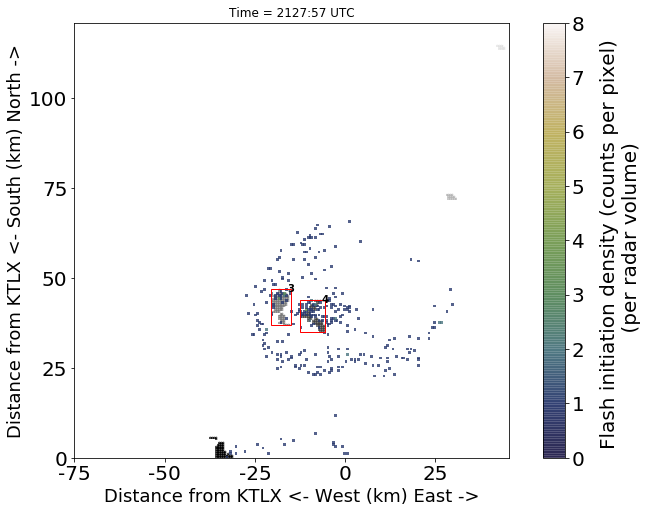

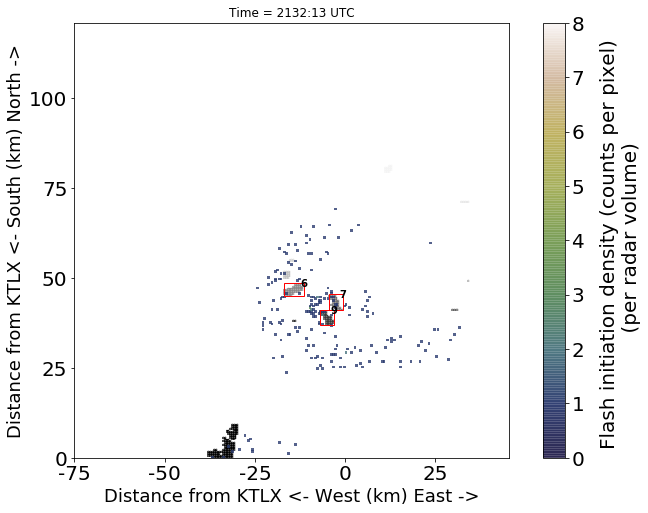

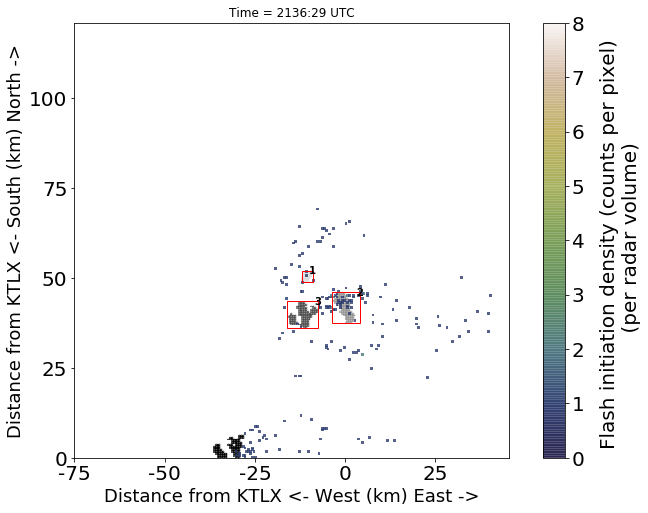

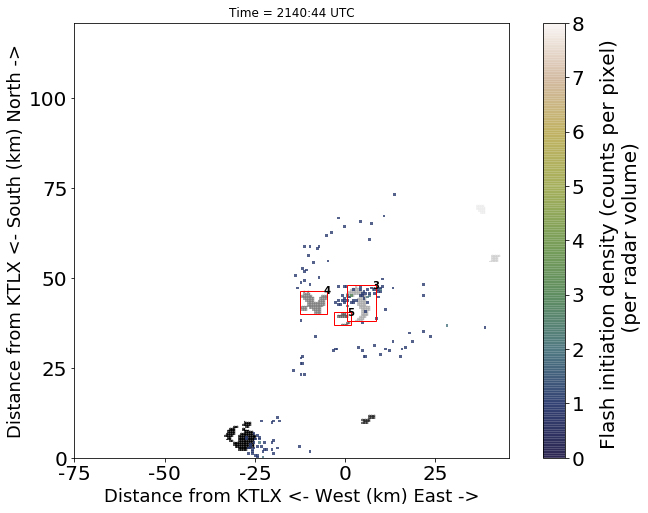

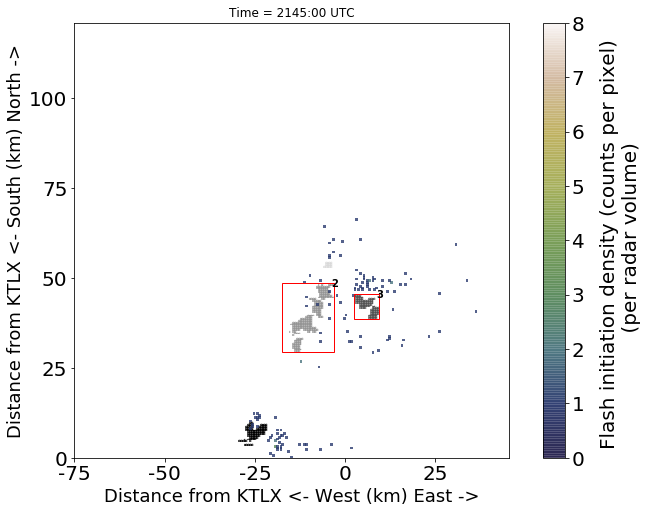

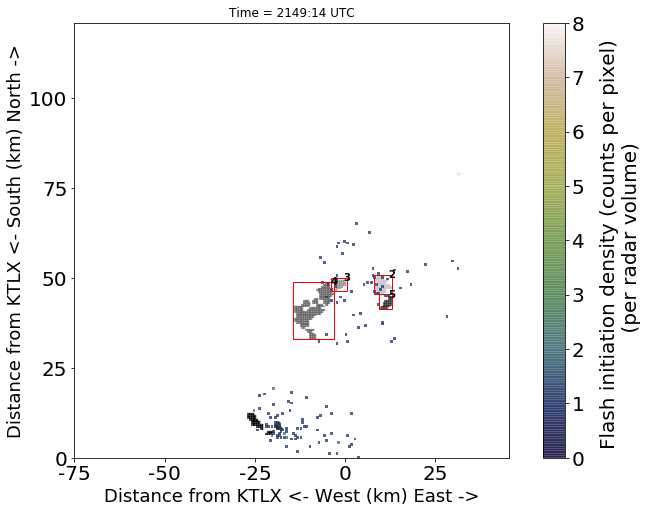

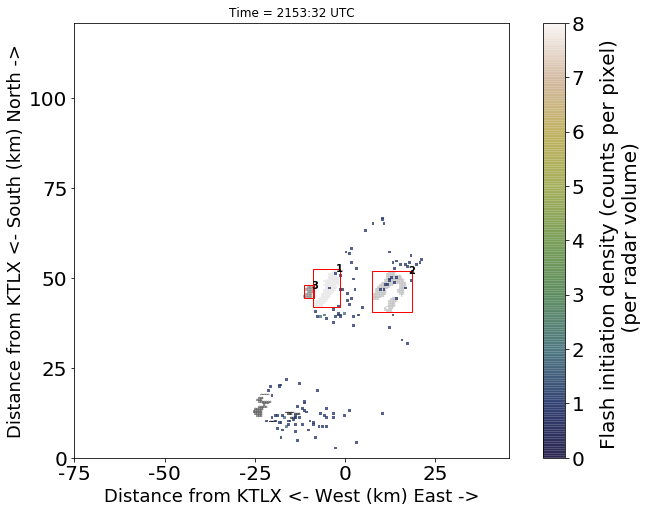

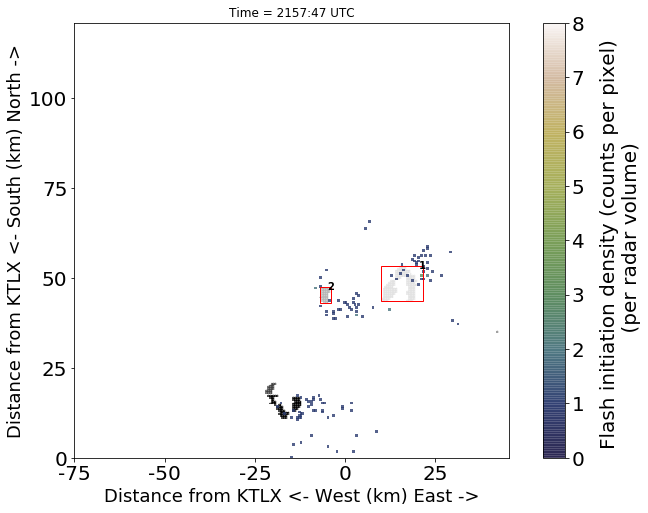

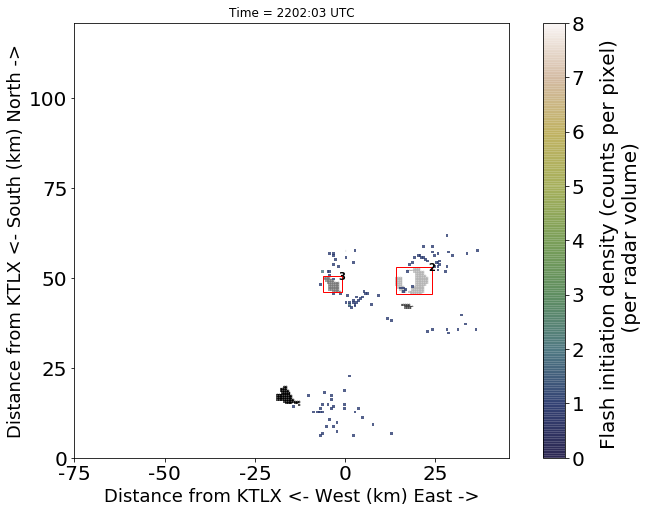

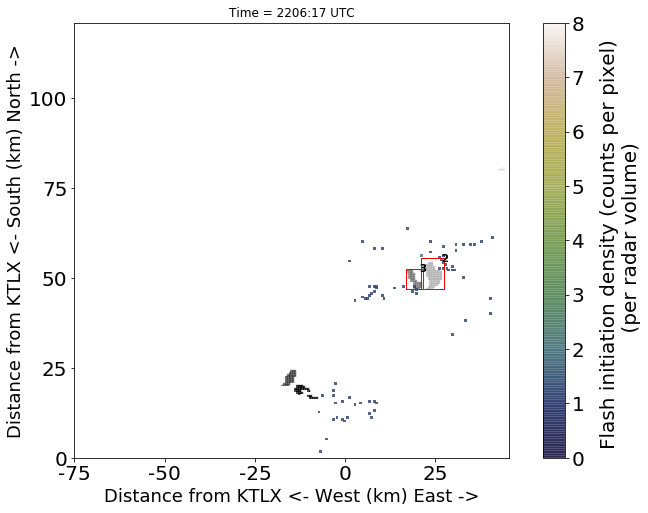

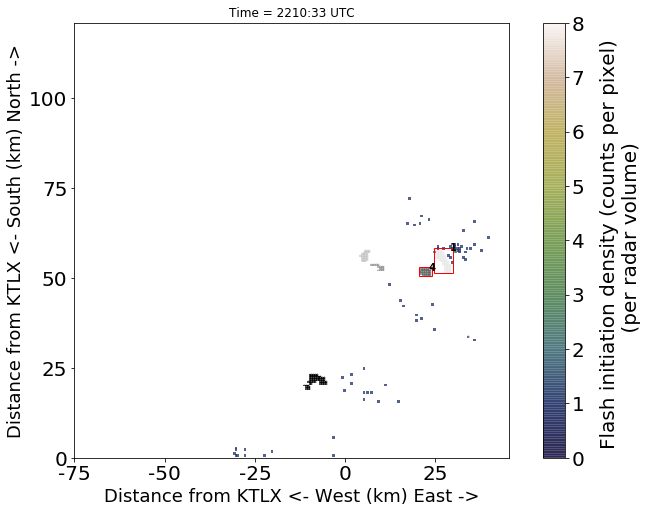

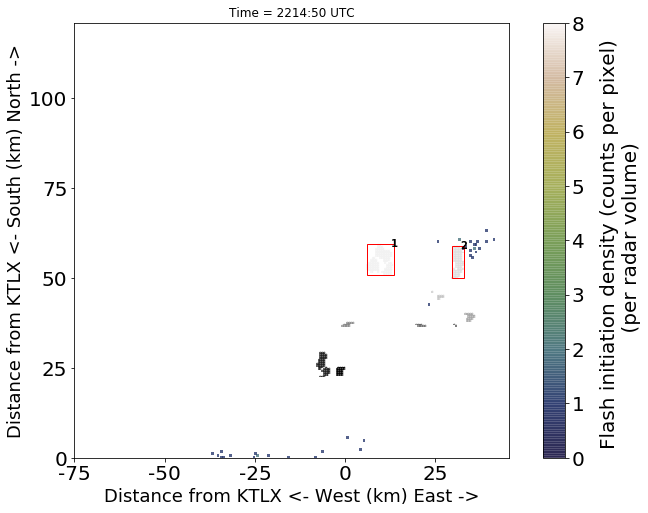

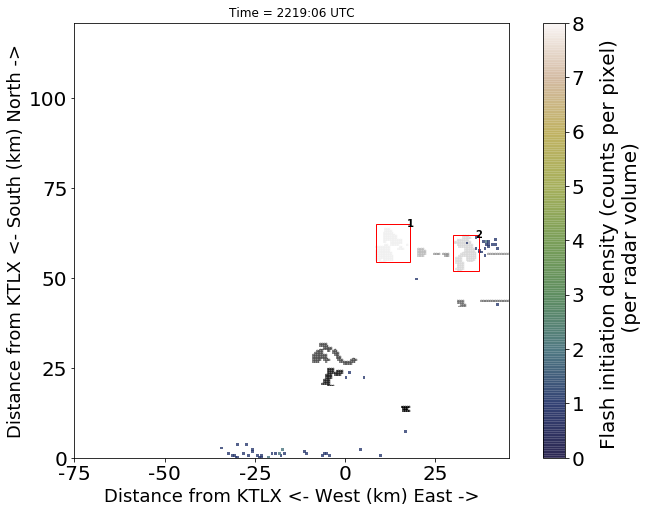

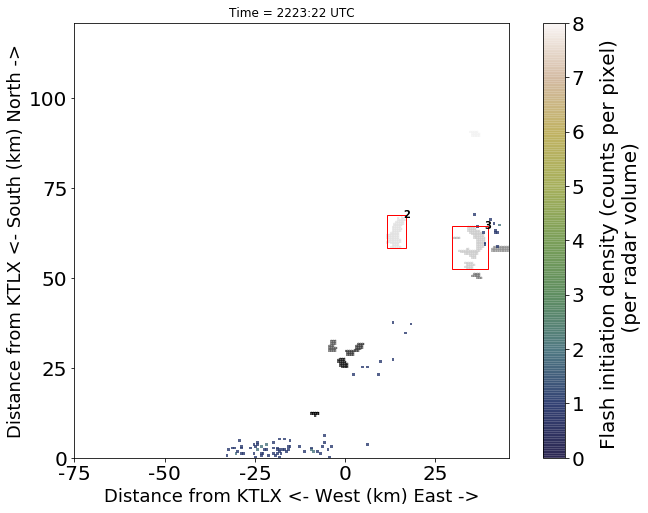

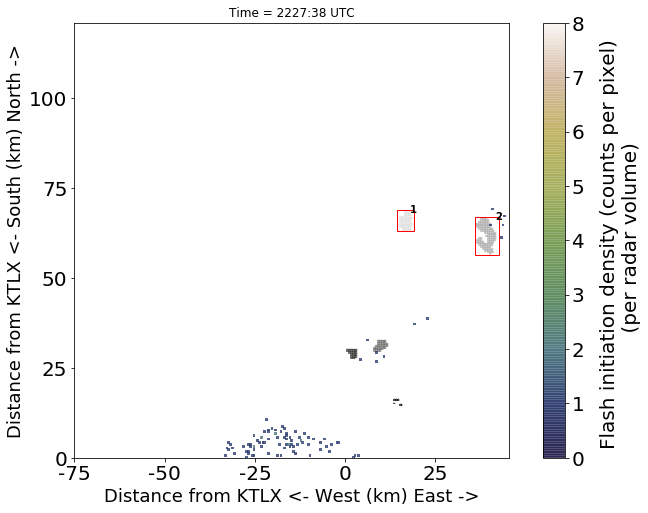

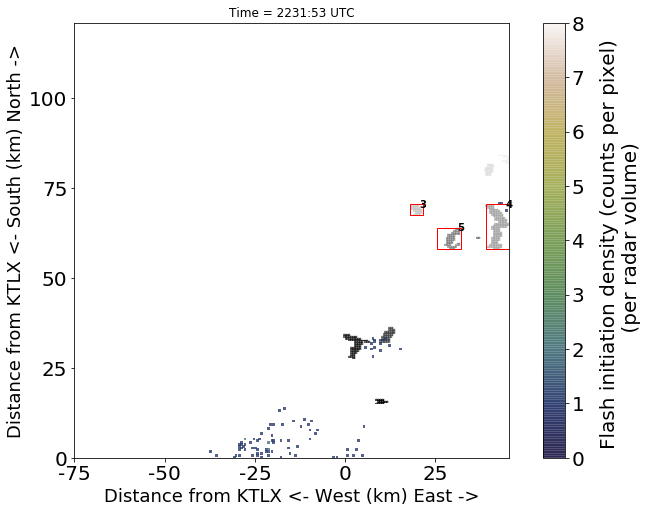

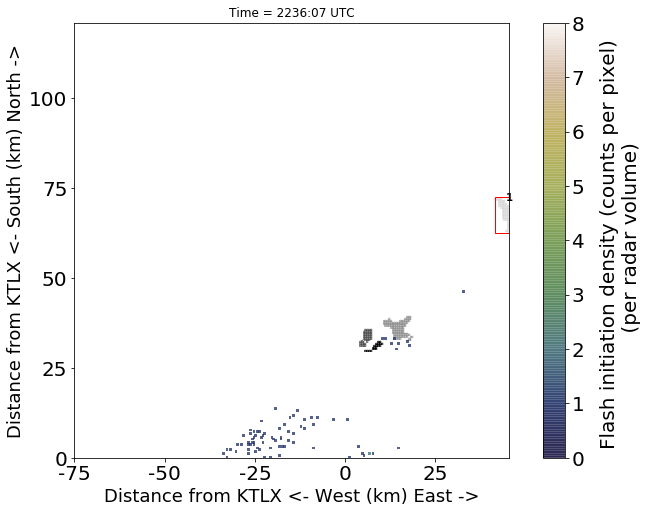

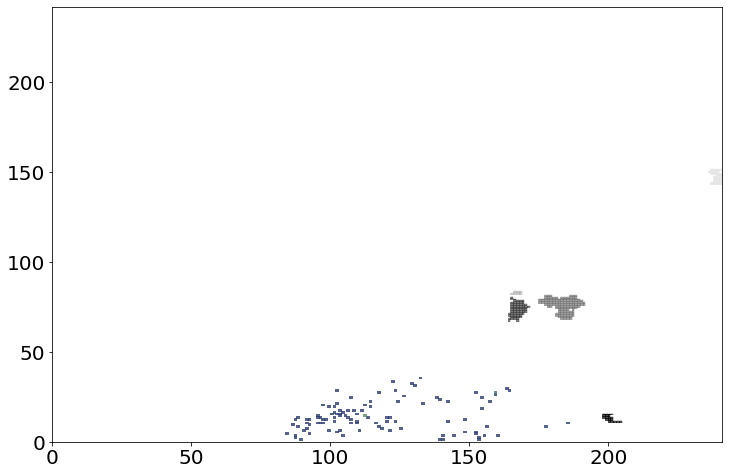

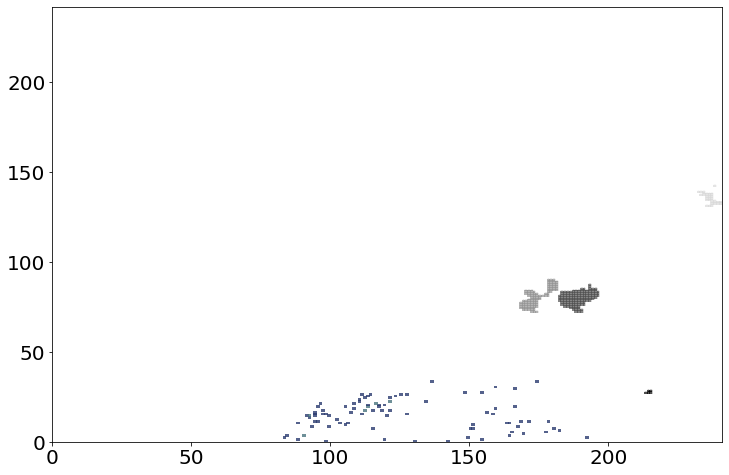

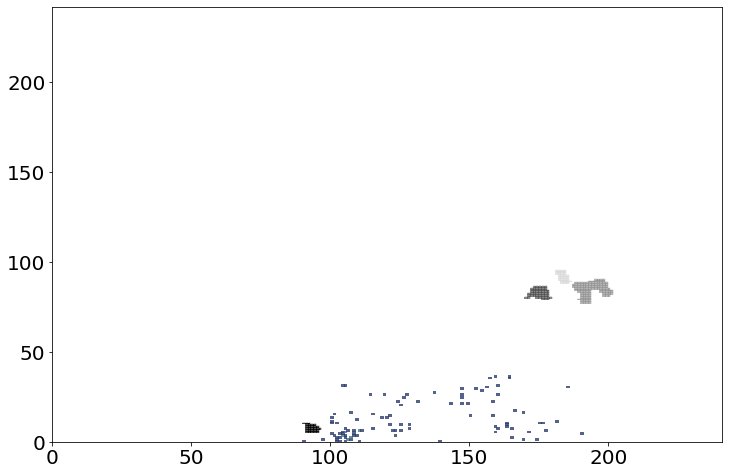

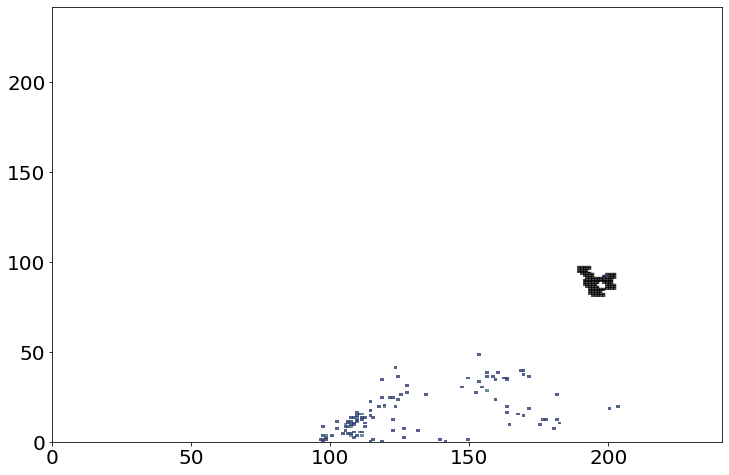

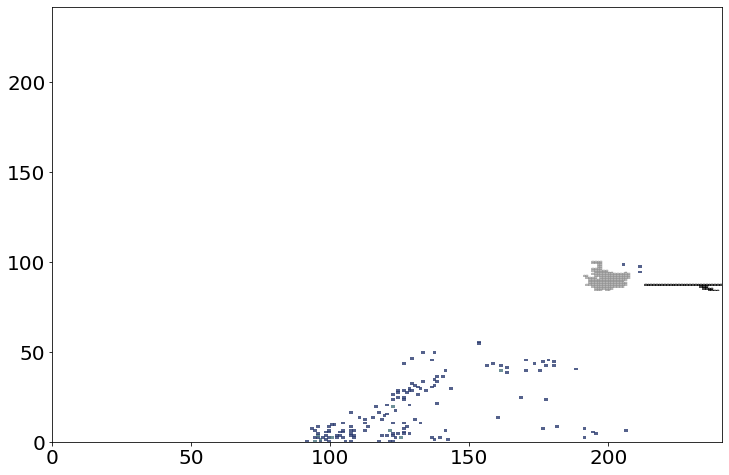

In [9]:
# This piece of code plots and overlays identified zdr column objects on top of flash initiation density

ds = xr.open_mfdataset('/Users/ms/Desktop/mount/May_19_2013_all_stuff/May19_LMA_sorted/flashsort/grid_files20002300_per_radar_grid_500x500x500m_KTLX/2013/May/19/*_flash_init.nc',combine='nested',concat_dim='ntimes')
rot_corrected_flash_src = np.swapaxes(ds.flash_initiation,1,2)
rot_corrected_flash_src = rot_corrected_flash_src.where(rot_corrected_flash_src > 0 )


for i in range(ds.dims['ntimes']):
    fig,ax = plt.subplots(1)
    tidx = dt_tmpstmps[i]
    obj_bounds = pd.DataFrame()

    cell_seg_reader = io.imread(segmented_files[i])
    cell_seg = cell_seg_reader
    seg = label(cell_seg)
    seg = np.fliplr(seg)

    ax.pcolormesh(seg[0,:,:],cmap='Greys',alpha=0.7)
    fig = ax.pcolormesh(rot_corrected_flash_src[i,:,:],cmap='extent_density_b13',alpha=0.8,vmin=0,vmax=8)

    
    try:
        obj_bounds = pd.DataFrame(final_zdr_df.loc[tidx])
        
        if len(obj_bounds.columns) ==1:
            obj = obj_bounds.transpose()
            rect = patches.Rectangle((obj['bbox-2'][0],obj['bbox-1'][0]),obj['bbox-5'][0]-obj['bbox-2'][0],obj['bbox-4'][0]-obj['bbox-1'][0],linewidth=1,edgecolor='r',facecolor='none')
            ax.annotate(obj['label'][0], (obj['bbox-5'][0],obj['bbox-4'][0]), color='k', weight='bold',fontsize=10, ha='center', va='center')
            # Add the patch to the Axes
            ax.add_patch(rect)
            cbar = plt.colorbar(mappable=fig)
            cbar.set_label('Flash initiation density (counts per pixel) \n (per radar volume)', fontsize = 20, labelpad=16)
            ratio = 1
            xleft, xright = ax.get_xlim()
            ybottom, ytop = ax.get_ylim()
            # the abs method is used to make sure that all numbers are positive
            # because x and y axis of an axes maybe inversed.
            ax.set_aspect(abs((xright-xleft)/(ybottom-ytop))*ratio)
            ax.set_xticklabels(['-75','-50','-25','0','25'])     # since #grid cells = 241 correspond to half the distance dx=dy=500m
            ax.set_yticklabels(['0','25','50','75','100'])
            ax.set_xlabel('Distance from KTLX <- West (km) East ->')
            ax.set_ylabel('Distance from KTLX <- South (km) North ->')
            fsavename = segmented_files[i].split('/')[-1].split('.')[0]
            raw_title  = datetime.strptime(segmented_files[i].split('/')[-1].split('.')[0],'%H%M%S')
            final_title = datetime.strftime(raw_title,'%H%M:%S') + ' UTC'
            
            plt.title(f'Time = {final_title}')
            plt.show()
            
        if len(obj_bounds.columns) >1:
            for j in range(len(obj_bounds)):
                obj = pd.DataFrame(obj_bounds.iloc[j]).transpose()
                rect = patches.Rectangle((obj['bbox-2'][0],obj['bbox-1'][0]),obj['bbox-5'][0]-obj['bbox-2'][0],obj['bbox-4'][0]-obj['bbox-1'][0],linewidth=1,edgecolor='r',facecolor='none')
                ax.annotate(obj['label'][0], (obj['bbox-5'][0],obj['bbox-4'][0]), color='k', weight='bold',fontsize=10, ha='center', va='center')
                # Add the patch to the Axes
                ax.add_patch(rect)
#                 ax.colorbar()
            cbar = plt.colorbar(mappable=fig)
            cbar.set_label('Flash initiation density (counts per pixel) \n (per radar volume)', fontsize = 20, labelpad=16)
            ratio = 1
            xleft, xright = ax.get_xlim()
            ybottom, ytop = ax.get_ylim()
            # the abs method is used to make sure that all numbers are positive
            # because x and y axis of an axes maybe inversed.
            ax.set_aspect(abs((xright-xleft)/(ybottom-ytop))*ratio)
            ax.set_xticklabels(['-75','-50','-25','0','25'])     # since #grid cells = 241 correspond to half the distance dx=dy=500m
            ax.set_yticklabels(['0','25','50','75','100'])
            ax.set_xlabel('Distance from KTLX <- West (km) East ->')
            ax.set_ylabel('Distance from KTLX <- South (km) North ->')
            fsavename = segmented_files[i].split('/')[-1].split('.')[0]
            raw_title  = datetime.strptime(segmented_files[i].split('/')[-1].split('.')[0],'%H%M%S')
            final_title = datetime.strftime(raw_title,'%H%M:%S') + ' UTC'
            
            plt.title(f'Time = {final_title}')
            plt.show()
    
    except KeyError as error:    # happens when  obj_pounds is empty (zero entries) i.e. no ZDR objects to identify in our data
        continue        

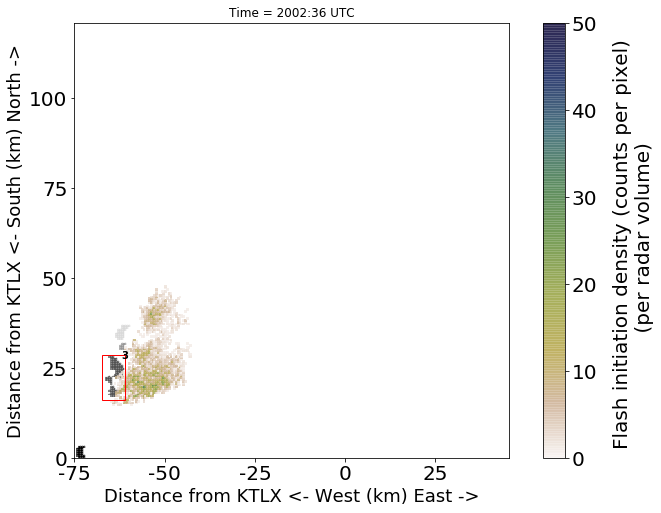

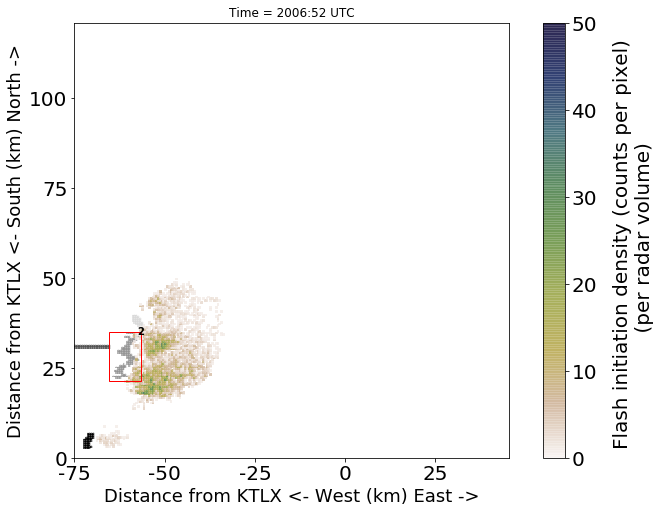

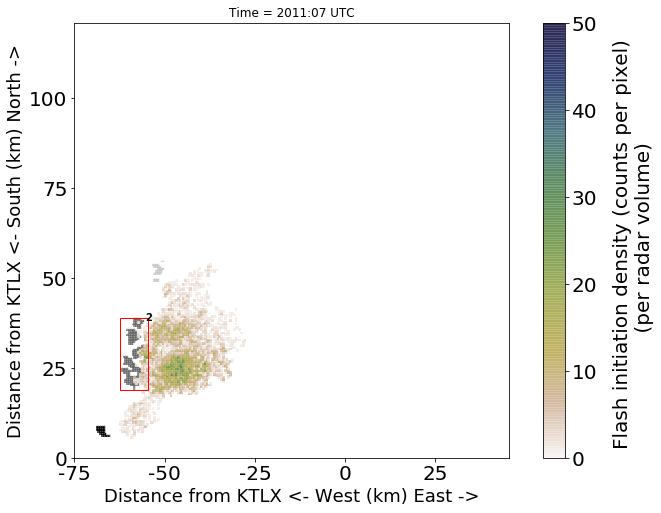

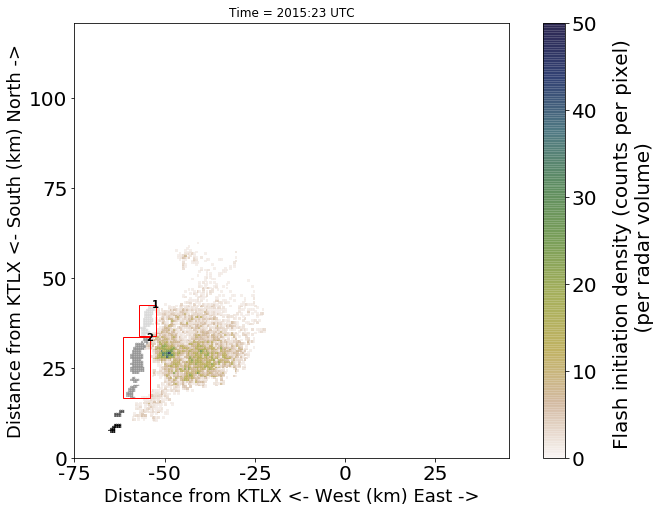

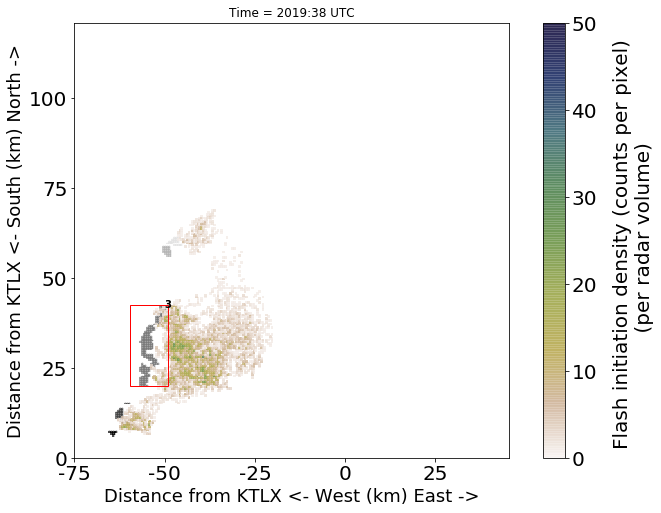

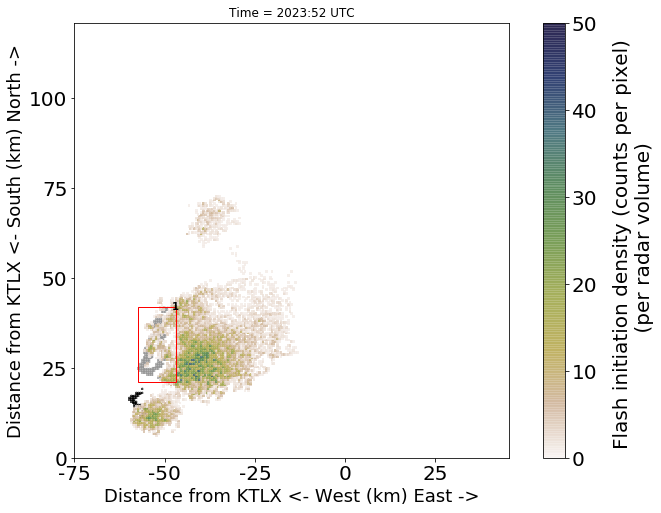

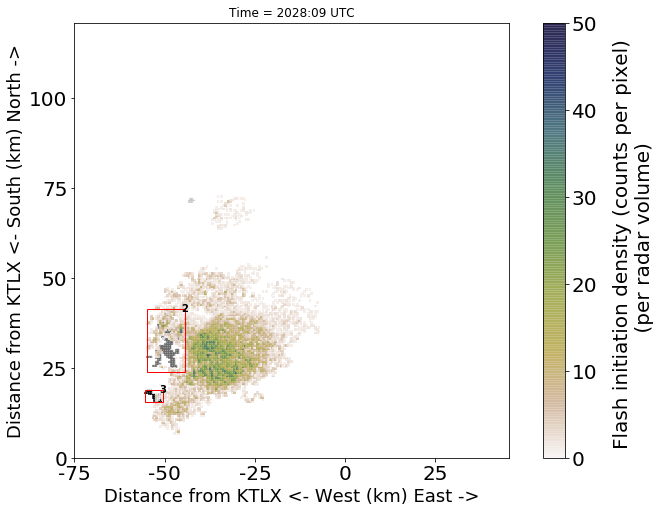

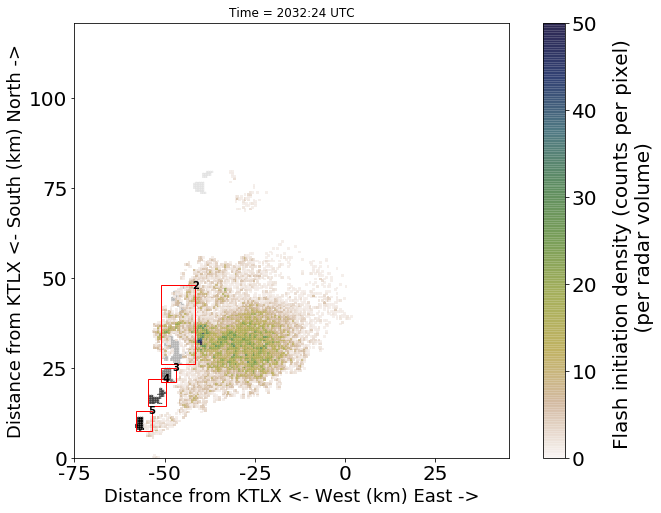

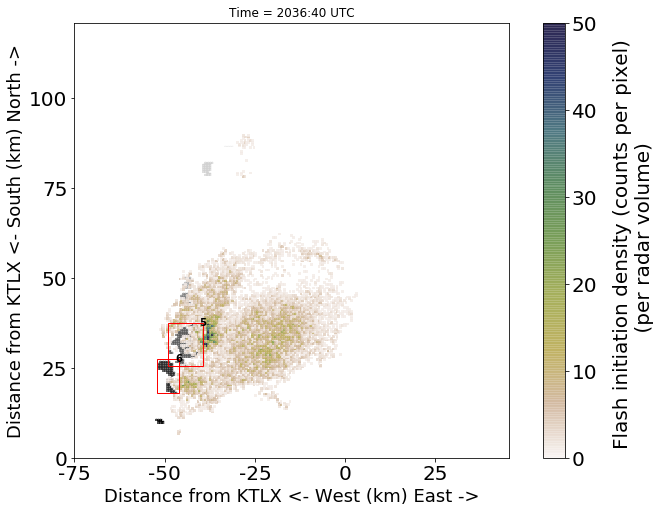

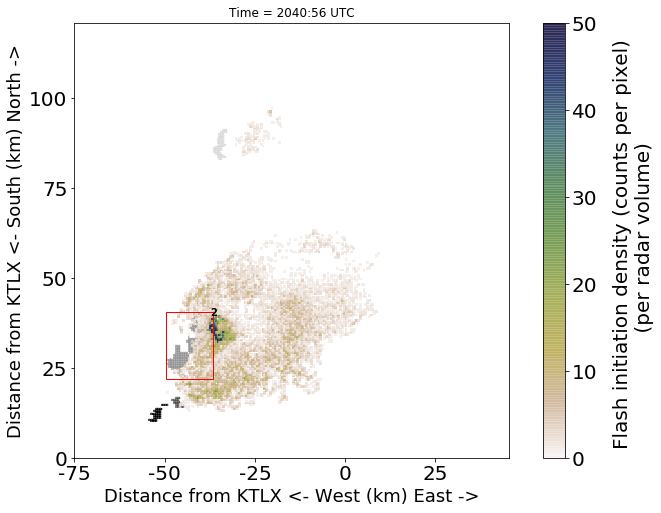

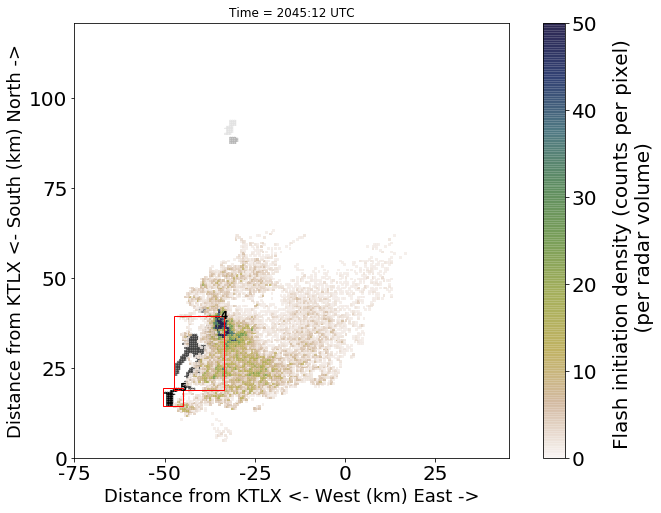

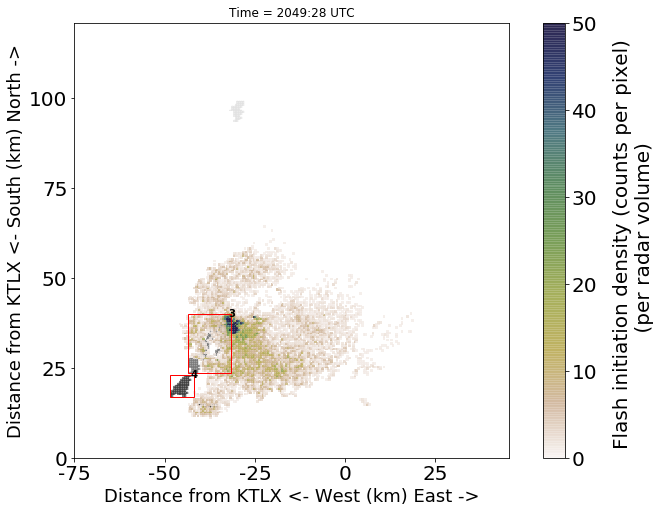

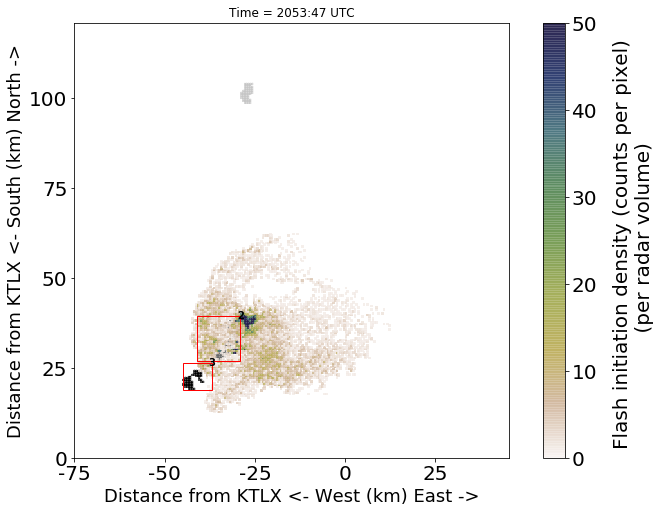

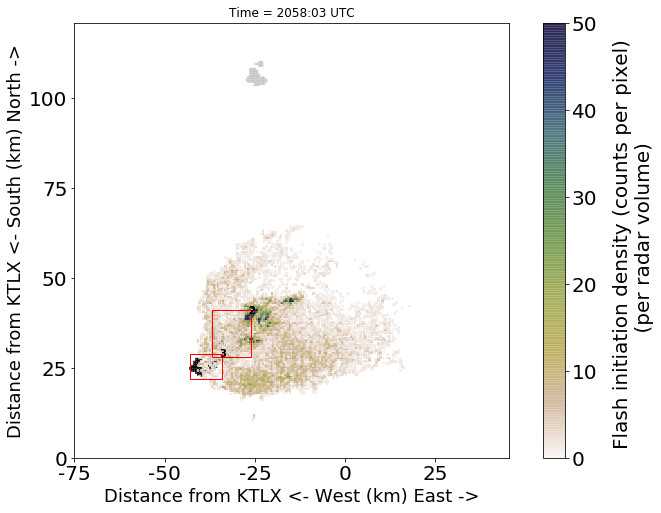

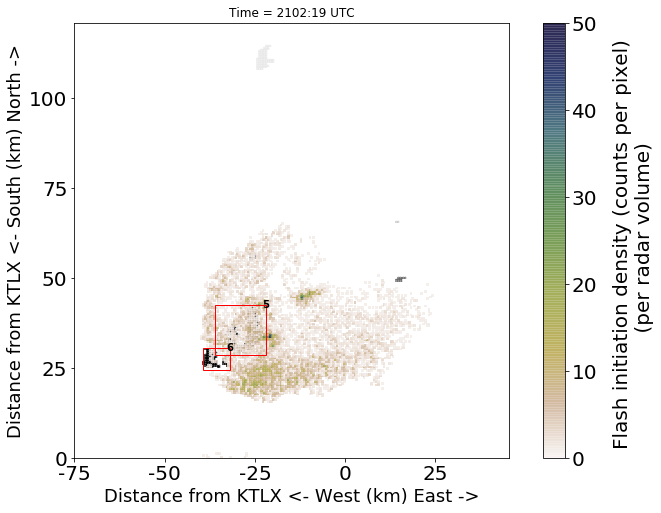

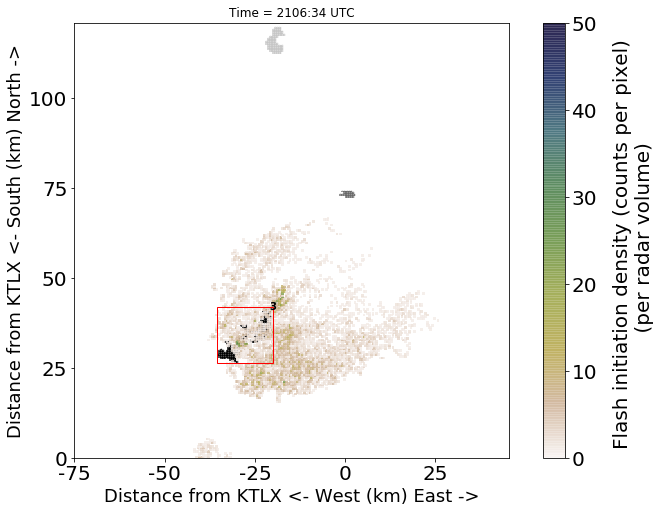

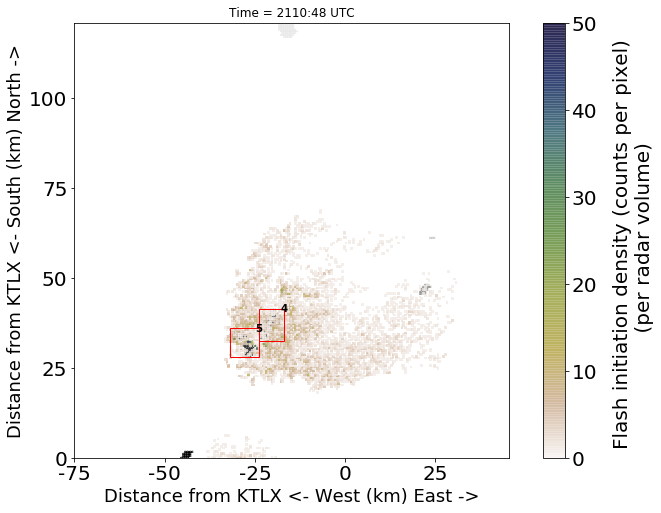

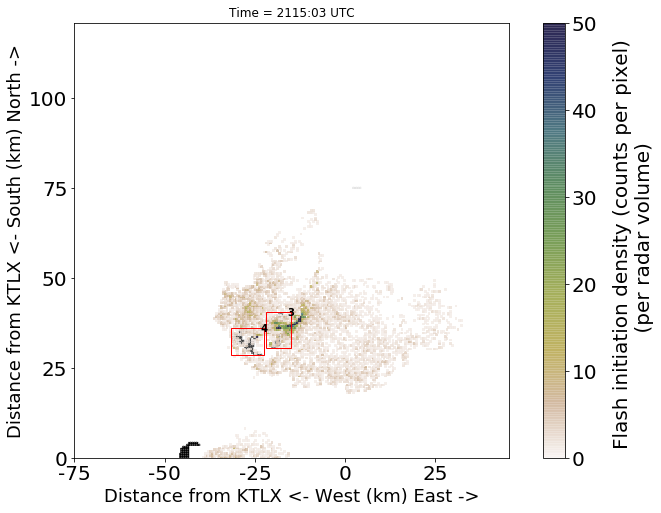

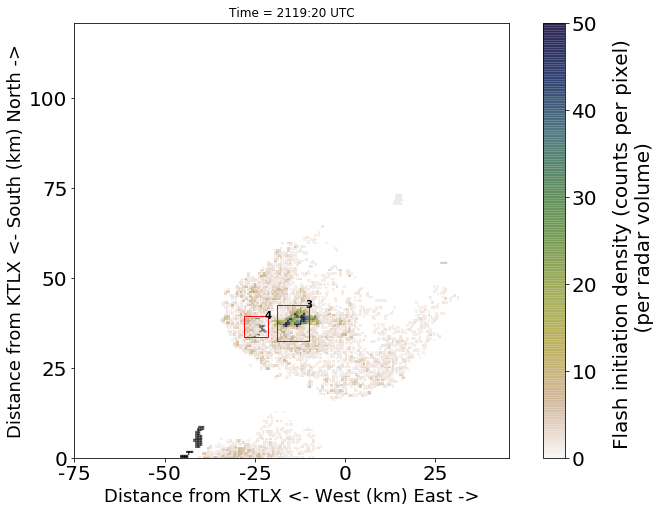

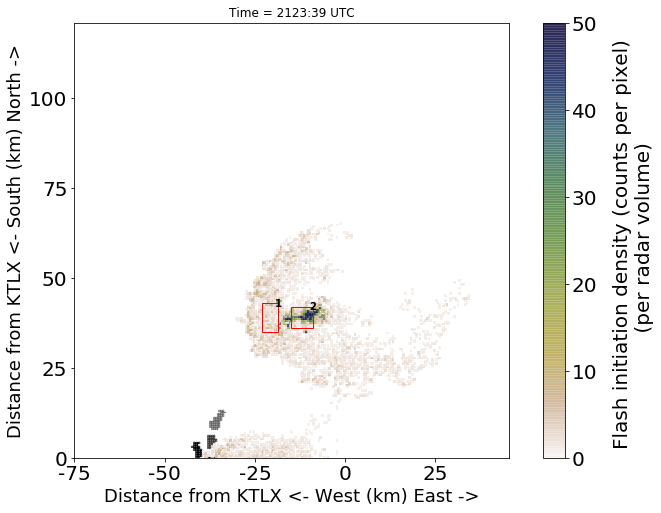

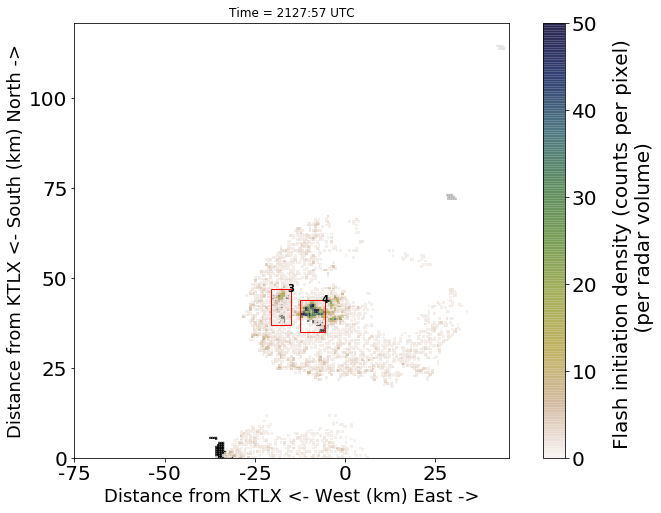

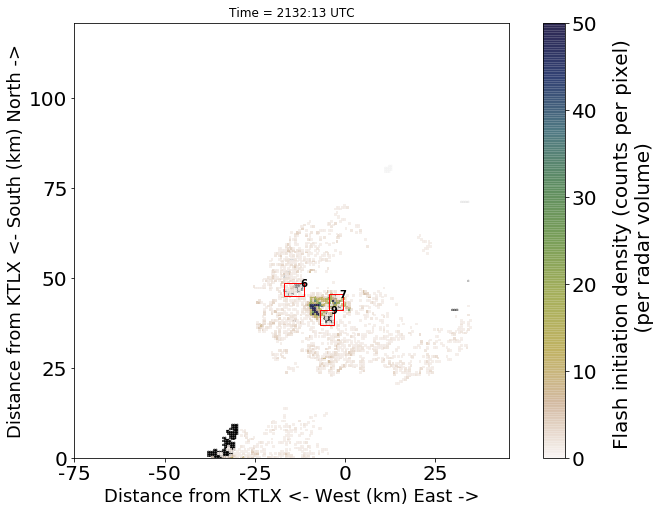

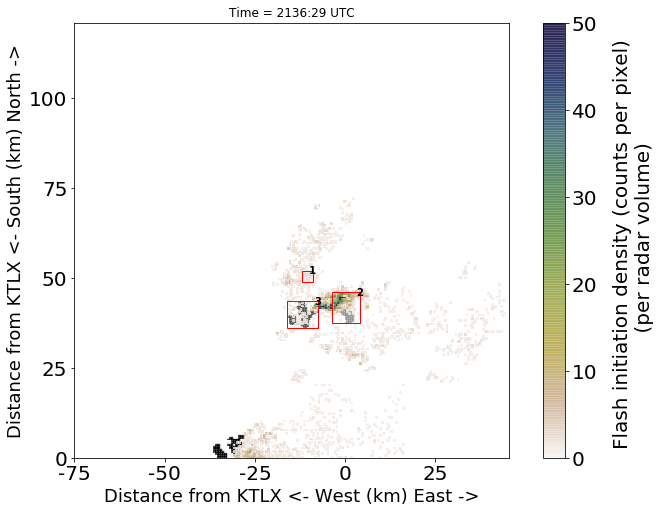

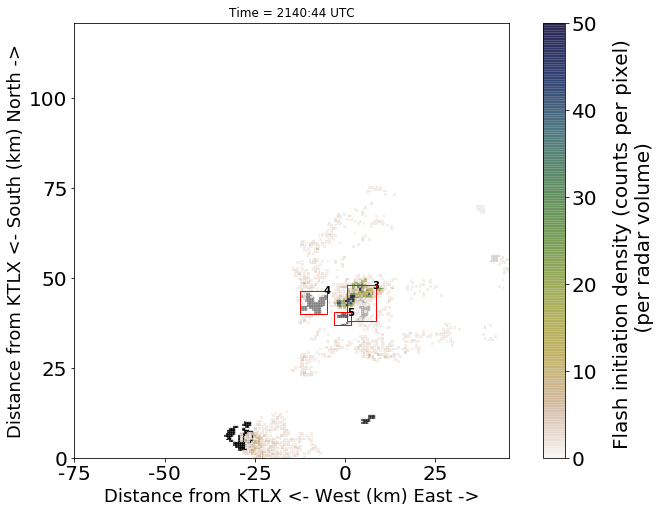

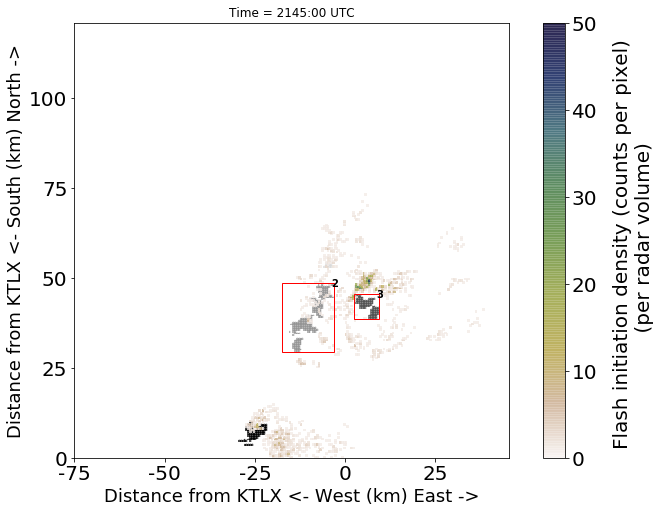

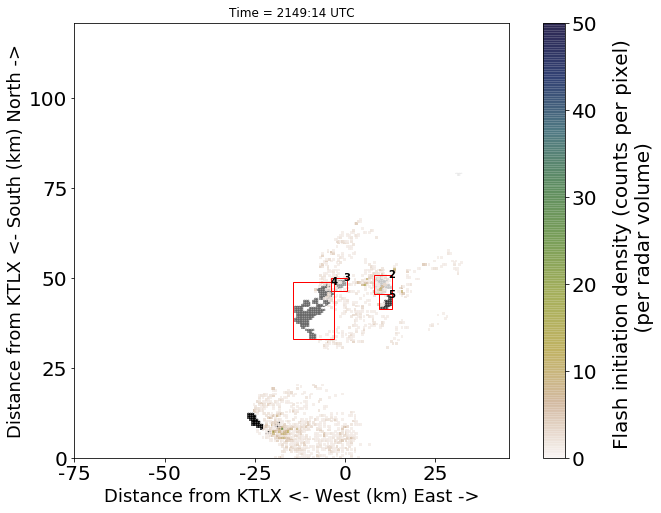

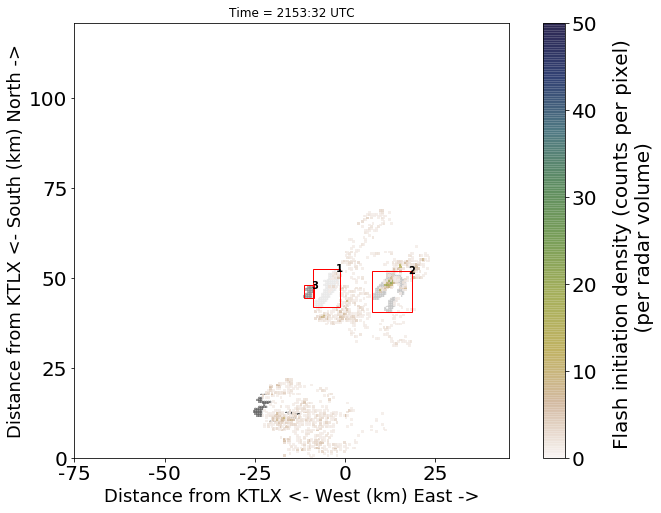

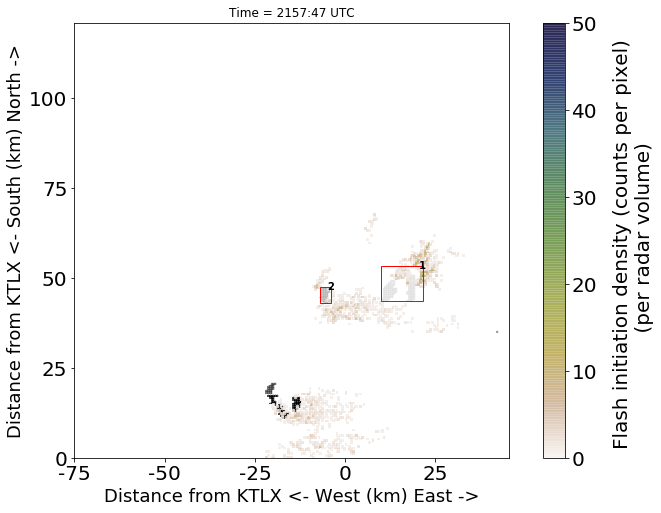

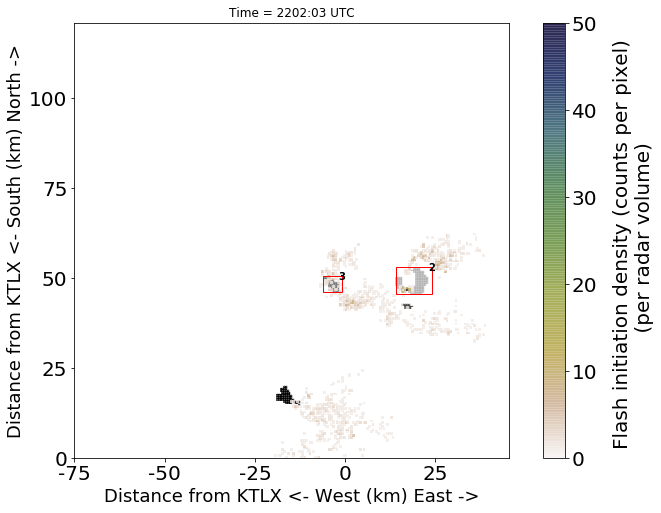

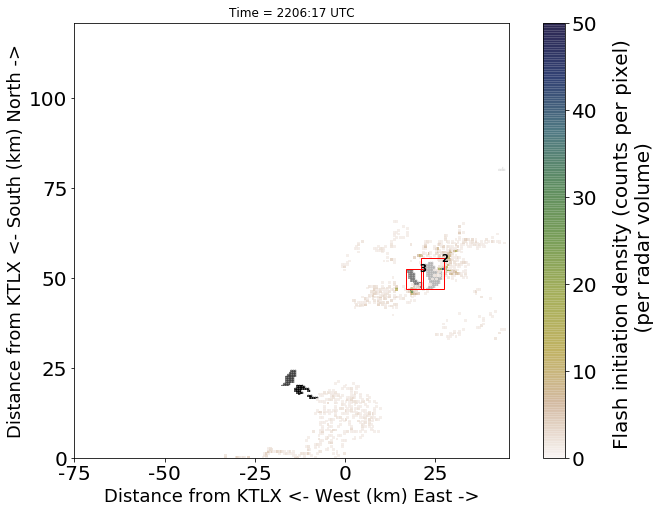

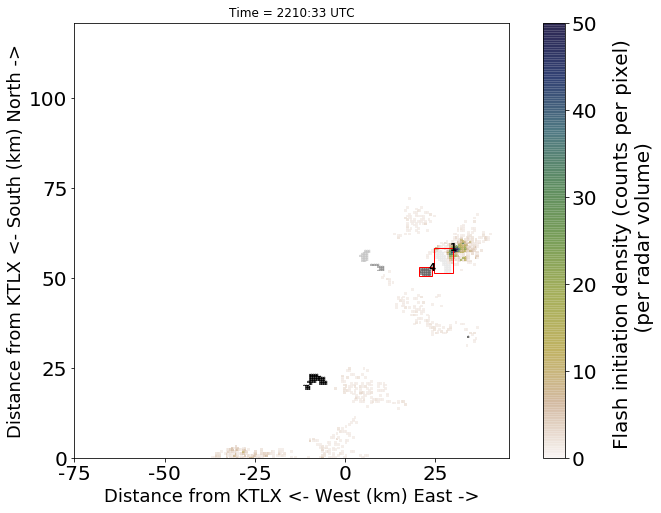

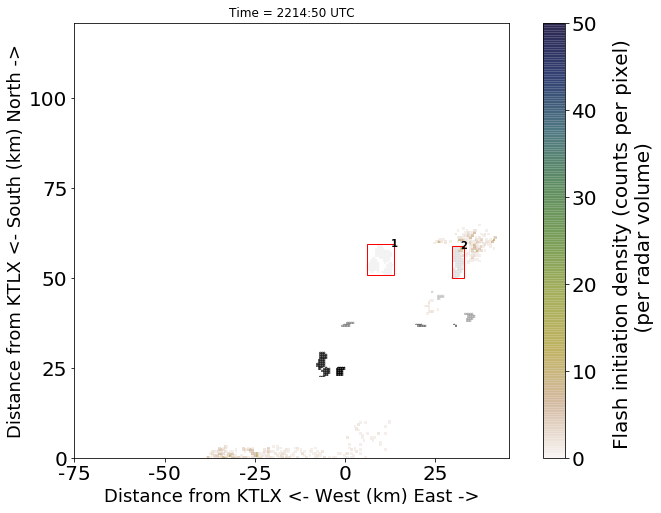

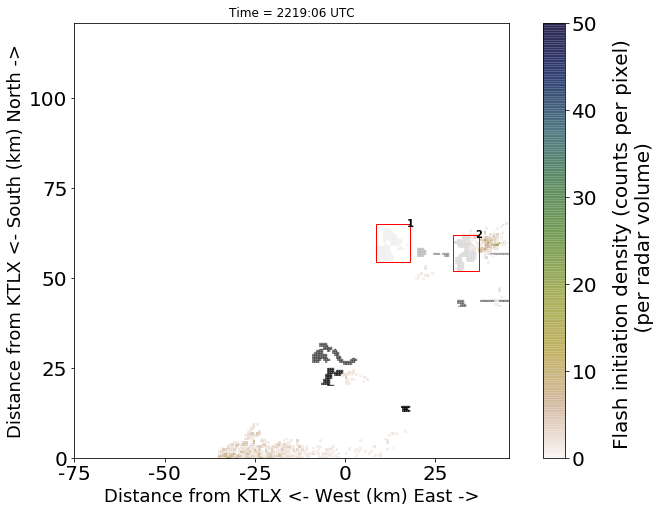

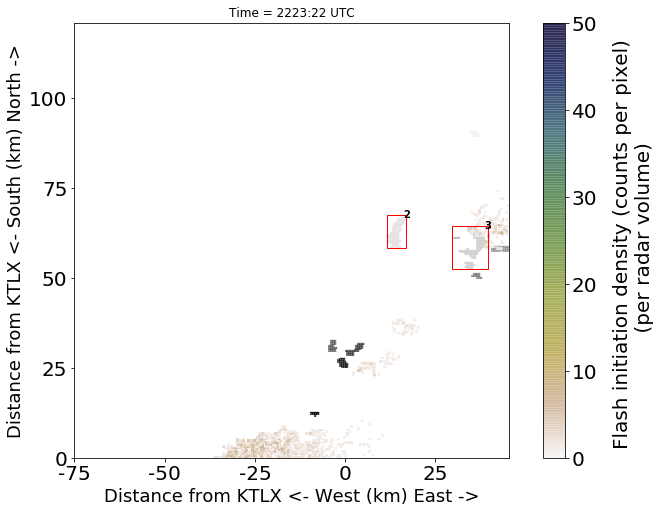

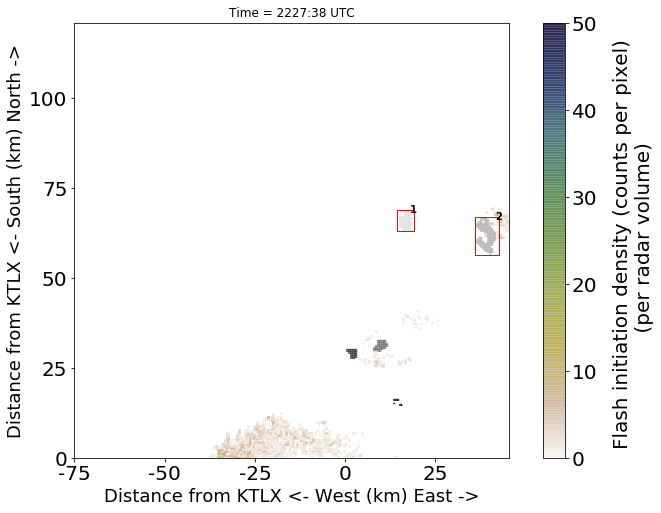

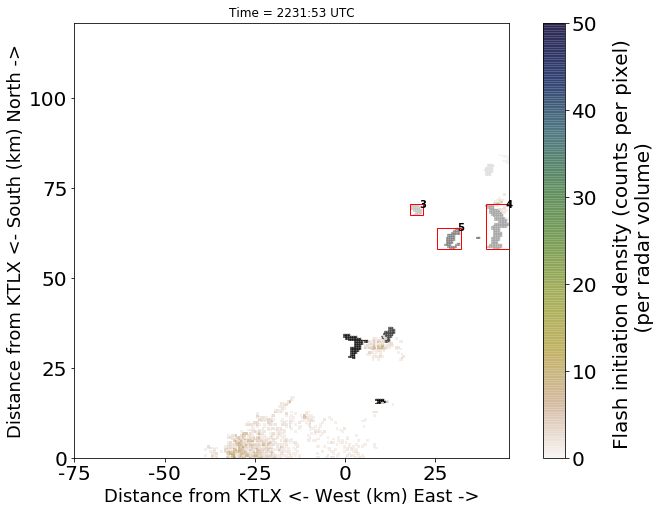

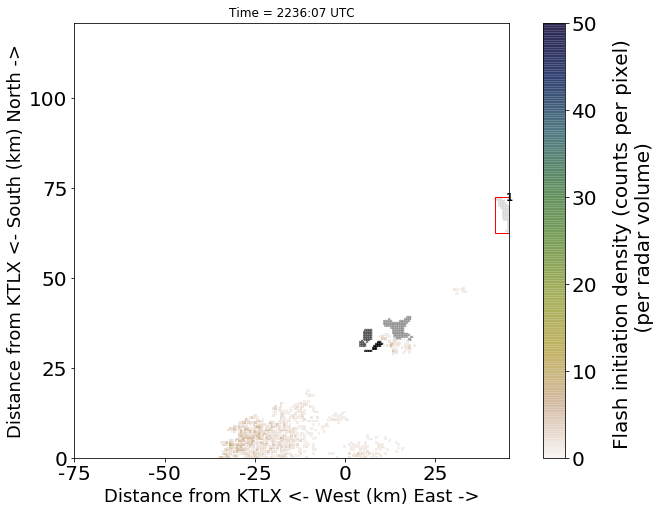

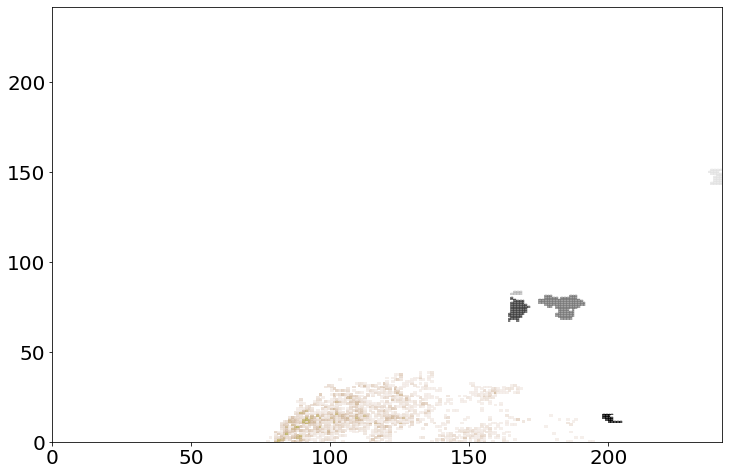

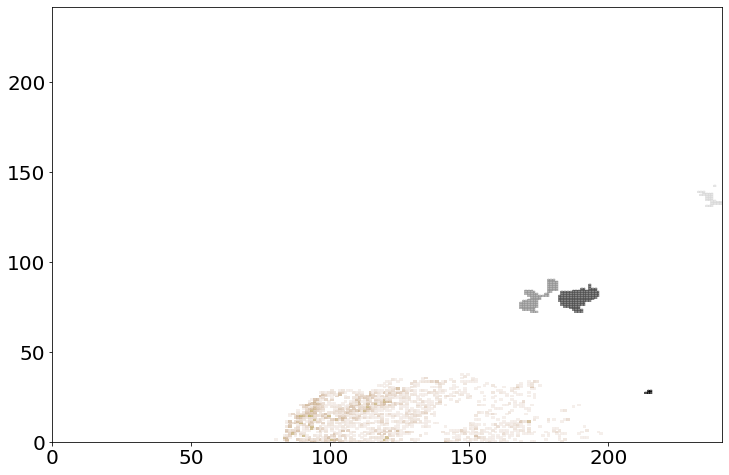

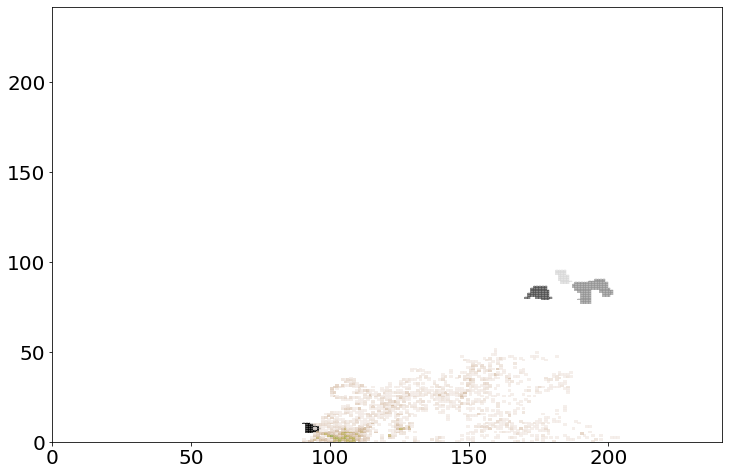

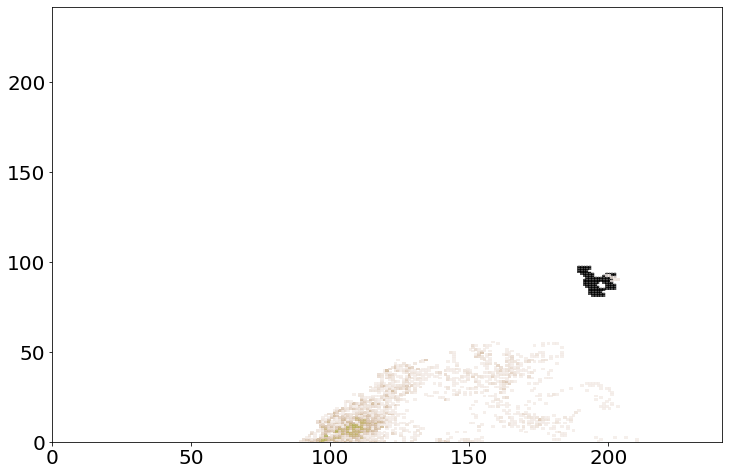

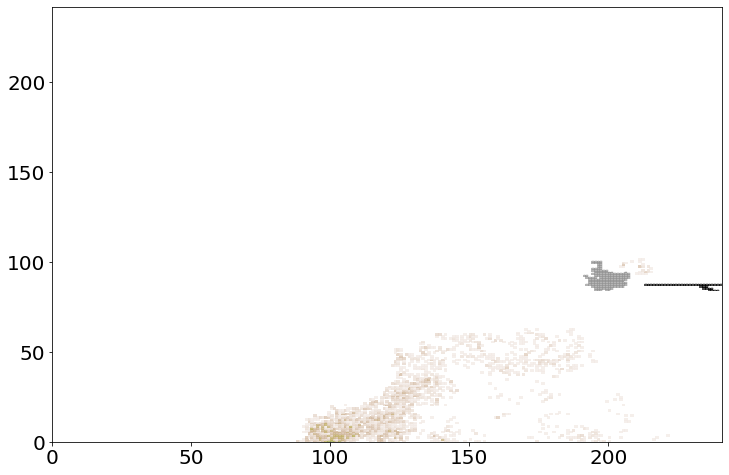

In [11]:
# This piece of code plots and overlays identified zdr column objects on top of flash source density

ds = xr.open_mfdataset('/Users/ms/Desktop/mount/May_19_2013_all_stuff/May19_LMA_sorted/flashsort/grid_files20002300_per_radar_grid_500x500x500m_KTLX/2013/May/19/*_source.nc',combine='nested',concat_dim='ntimes')
rot_corrected_flash_src = np.swapaxes(ds.lma_source,1,2)
rot_corrected_flash_src = rot_corrected_flash_src.where(rot_corrected_flash_src > 0 )


for i in range(ds.dims['ntimes']):
    fig,ax = plt.subplots(1)
    tidx = dt_tmpstmps[i]
    obj_bounds = pd.DataFrame()

    cell_seg_reader = io.imread(segmented_files[i])
    cell_seg = cell_seg_reader
    seg = label(cell_seg)
    seg = np.fliplr(seg)

#     ax.pcolormesh(ds.flash_initiation[i,:,:])
    ax.pcolormesh(seg[0,:,:],cmap='Greys',alpha=0.7)
    fig = ax.pcolormesh(rot_corrected_flash_src[i,:,:],cmap='extent_density_b13_r',alpha=0.8,vmin=0,vmax=50)

    
    try:
        obj_bounds = pd.DataFrame(final_zdr_df.loc[tidx])
        
        if len(obj_bounds.columns) ==1:
            obj = obj_bounds.transpose()
            rect = patches.Rectangle((obj['bbox-2'][0],obj['bbox-1'][0]),obj['bbox-5'][0]-obj['bbox-2'][0],obj['bbox-4'][0]-obj['bbox-1'][0],linewidth=1,edgecolor='r',facecolor='none')
            ax.annotate(obj['label'][0], (obj['bbox-5'][0],obj['bbox-4'][0]), color='k', weight='bold',fontsize=10, ha='center', va='center')
            # Add the patch to the Axes
            ax.add_patch(rect)
            cbar = plt.colorbar(mappable=fig)
            cbar.set_label('Flash initiation density (counts per pixel) \n (per radar volume)', fontsize = 20, labelpad=16)
            ratio = 1
            xleft, xright = ax.get_xlim()
            ybottom, ytop = ax.get_ylim()
            # the abs method is used to make sure that all numbers are positive
            # because x and y axis of an axes maybe inversed.
            ax.set_aspect(abs((xright-xleft)/(ybottom-ytop))*ratio)
            
            # As per jupyter_notebooks_May19_observational_analysis_extended/Allen_Center_segmentation_and_analysis/flashsort_as_per_KTLX.ipynb file,
            # x_bnd=(-75.25e3, 45.25e3), y_bnd=(-0.25e3, 120.25e3). Thus, 240 grid points in x and y directions are within these x_bnd and y_bnd limits

            ax.set_xticklabels(['-75','-50','-25','0','25'])     # since #grid cells = 241 correspond to half the distance dx=dy=500m
            ax.set_yticklabels(['0','25','50','75','100'])
            ax.set_xlabel('Distance from KTLX <- West (km) East ->')
            ax.set_ylabel('Distance from KTLX <- South (km) North ->')
            fsavename = segmented_files[i].split('/')[-1].split('.')[0]
            raw_title  = datetime.strptime(segmented_files[i].split('/')[-1].split('.')[0],'%H%M%S')
            final_title = datetime.strftime(raw_title,'%H%M:%S') + ' UTC'
            
            plt.title(f'Time = {final_title}')
#             plt.savefig(f'/Users/ms/Desktop/mount/May_19_2013_all_stuff/flash_initiation_data_within_zdr_col_region/{fsavename}',bbox_inches='tight',dpi=300)
            plt.show()
#             plt.colorbar()
            
        if len(obj_bounds.columns) >1:
            for j in range(len(obj_bounds)):
                obj = pd.DataFrame(obj_bounds.iloc[j]).transpose()
                rect = patches.Rectangle((obj['bbox-2'][0],obj['bbox-1'][0]),obj['bbox-5'][0]-obj['bbox-2'][0],obj['bbox-4'][0]-obj['bbox-1'][0],linewidth=1,edgecolor='r',facecolor='none')
                ax.annotate(obj['label'][0], (obj['bbox-5'][0],obj['bbox-4'][0]), color='k', weight='bold',fontsize=10, ha='center', va='center')
                # Add the patch to the Axes
                ax.add_patch(rect)
#                 ax.colorbar()
            cbar = plt.colorbar(mappable=fig)
            cbar.set_label('Flash initiation density (counts per pixel) \n (per radar volume)', fontsize = 20, labelpad=16)
            ratio = 1
            xleft, xright = ax.get_xlim()
            ybottom, ytop = ax.get_ylim()
            # the abs method is used to make sure that all numbers are positive
            # because x and y axis of an axes maybe inversed.
            ax.set_aspect(abs((xright-xleft)/(ybottom-ytop))*ratio)
            
            # As per jupyter_notebooks_May19_observational_analysis_extended/Allen_Center_segmentation_and_analysis/flashsort_as_per_KTLX.ipynb file,
            # x_bnd=(-75.25e3, 45.25e3), y_bnd=(-0.25e3, 120.25e3). Thus, 240 grid points in x and y directions are within these x_bnd and y_bnd limits

            ax.set_xticklabels(['-75','-50','-25','0','25'])     # since #grid cells = 241 correspond to half the distance dx=dy=500m
            ax.set_yticklabels(['0','25','50','75','100'])
            ax.set_xlabel('Distance from KTLX <- West (km) East ->')
            ax.set_ylabel('Distance from KTLX <- South (km) North ->')
            fsavename = segmented_files[i].split('/')[-1].split('.')[0]
            raw_title  = datetime.strptime(segmented_files[i].split('/')[-1].split('.')[0],'%H%M%S')
            final_title = datetime.strftime(raw_title,'%H%M:%S') + ' UTC'
            
            plt.title(f'Time = {final_title}')
#             plt.savefig(f'/Users/ms/Desktop/mount/May_19_2013_all_stuff/flash_initiation_data_within_zdr_col_region/{fsavename}',bbox_inches='tight',dpi=300)
#             plt.savefig(f'/Users/ms/Desktop/haha.png',dpi=300)
            plt.show()
    
    except KeyError as error:    # happens when  obj_pounds is empty (zero entries) i.e. no ZDR objects to identify in our data
        continue        
    
#     print(f'Frame {i} done')